# **Trabalhando com dados de texto**

---

## **1 - Tokenização de texto**

O texto que tokenizaremos para o treinamento em LLM é "O Veredito", um conto de Edith Wharton, que foi lançado em domínio público e, portanto, pode ser usado em tarefas de treinamento em LLM. O texto está disponível no [Wikisource](https://en.wikisource.org/wiki/The_Verdict), e você pode copiá-lo e colá-lo em um arquivo de texto, que eu copiei para o arquivo de texto "the-verdict.txt".

Alternativamente, você pode encontrar o arquivo "the-verdict.txt" no repositório GitHub deste [livro](https://mng.bz/Adng). Você pode baixar o arquivo com o seguinte código Python:

In [ ]:
# Importa o módulo 'urllib.request', que é usado para lidar com URLs.
# Este módulo fornece funções para abrir e ler URLs.
import urllib.request

# Define a URL do arquivo de texto que será baixado.
# A string é quebrada em várias linhas para melhor legibilidade, mas é uma única URL.
# A URL aponta para o arquivo "the-verdict.txt" em um repositório do GitHub.
url = ("https://raw.githubusercontent.com/rasbt/"
      "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
      "the-verdict.txt")

# Define o caminho onde o arquivo baixado será salvo localmente.
# Neste caso, o arquivo será salvo com o nome "the-veredict.txt" no diretório atual.
file_path = "the-veredict.txt"

# Usa a função 'urlretrieve' do módulo 'urllib.request' para baixar o arquivo.
# O primeiro argumento é a URL do arquivo a ser baixado ('url').
# O segundo argumento é o caminho onde o arquivo será salvo localmente ('file_path').
# Esta função baixa o conteúdo da URL e o salva no caminho especificado.
urllib.request.urlretrieve(url, file_path)

('the-veredict.txt', <http.client.HTTPMessage at 0x7e1747347ec0>)

Em  seguida,  podemos  carregar  o  arquivo  `the-verdict.txt`  usando  os  utilitários  de  leitura  de  arquivos  padrão  do  Python.

In [ ]:
# Abre o arquivo chamado "the-veredict.txt" no modo de leitura ('r').
# A codificação 'utf-8' é especificada para garantir que caracteres especiais sejam lidos corretamente.
# O 'with open(...) as f:' garante que o arquivo seja fechado automaticamente após o bloco de código.
with open ("the-veredict.txt", "r", encoding="utf-8") as f:
    # Lê todo o conteúdo do arquivo e o armazena na variável 'raw_text'.
    raw_text = f.read()

# Imprime o número total de caracteres no texto lido.
# A função 'len()' retorna o comprimento (número de caracteres) da string 'raw_text'.
print(f"Número total de caracteres: {len(raw_text)}")

# Imprime os primeiros 99 caracteres do texto lido.
# 'raw_text[:99]' usa fatiamento de string para obter os caracteres do início até o índice 98 (inclusive).
print(raw_text[:99])

Número total de caracteres: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


O comando print imprime o número total de caracteres seguido pelos primeiros 100 caracteres deste arquivo para fins ilustrativos.

Nosso objetivo é tokenizar esse conto de 20.479 caracteres em palavras individuais e caracteres especiais que podemos então transformar em incorporações para treinamento de LLM.

Como podemos dividir este texto da melhor forma para obter uma lista de tokens? Para isso, faremos uma pequena excursão e usaremos a biblioteca de expressões regulares re do Python para fins ilustrativos. (Você não precisa aprender ou memorizar nenhuma sintaxe de expressão regular, pois posteriormente faremos a transição para um tokenizador pré-construído.)

Usando um texto de exemplo simples, podemos usar o comando re.split com a seguinte sintaxe para dividir um texto em caracteres de espaço em branco:

In [ ]:
# Importa o módulo 're' (regular expression), que fornece operações com expressões regulares.
# Expressões regulares são sequências de caracteres que formam um padrão de busca.
import re

# Define uma string de texto simples para ser usada como exemplo.
text = "Hello, world. This, is a test."

# Usa a função 're.split' para dividir a string 'text' em uma lista.
# O primeiro argumento é o padrão da expressão regular a ser usada para a divisão.
# r'(\s)' é uma expressão regular que busca por caracteres de espaço em branco ('\s').
# Os parênteses ao redor de '\s' fazem com que o delimitador (o espaço em branco) também seja incluído na lista resultante.
# O segundo argumento é a string a ser dividida ('text').
result = re.split(r'(\s)', text)

# Imprime a lista resultante após a divisão.
# Cada elemento da lista será uma palavra ou um caractere de espaço em branco.
print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


Este esquema simples de tokenização funciona principalmente para separar o texto de exemplo em palavras individuais; no entanto, algumas palavras ainda estão conectadas a caracteres de pontuação que queremos ter como entradas separadas na lista. Também evitamos escrever todo o texto em minúsculas, pois o uso de letras maiúsculas ajuda os LLMs a distinguir entre nomes próprios e substantivos comuns, a entender a estrutura das frases e a aprender a gerar texto com letras maiúsculas corretamente.

Vamos modificar as divisões da expressão regular em espaços em branco (\s), vírgulas e pontos finais ([,.]):

In [ ]:
# Usa a função 're.split' do módulo 're' para dividir a string 'text'.
# O primeiro argumento é o padrão da expressão regular a ser usada para a divisão.
# r'([,.]|\s)' é uma expressão regular que busca por:
#   - [,.] : vírgulas ou pontos finais (caracteres dentro dos colchetes).
#   - |  : o operador OR, significando "ou".
#   - \s : caracteres de espaço em branco (espaços, tabs, novas linhas).
# Os parênteses ao redor de '[,.]|\s' fazem com que os delimitadores (vírgulas, pontos ou espaços em branco) também sejam incluídos na lista resultante.
# O segundo argumento é a string a ser dividida ('text').
result = re.split(r'([,.]|\s)', text)

# Imprime a lista resultante após a divisão.
# Cada elemento da lista será uma palavra, vírgula, ponto final ou espaço em branco.
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


Um pequeno problema remanescente é que a lista ainda inclui caracteres de espaço em branco. Opcionalmente, podemos remover esses caracteres redundantes com segurança da seguinte maneira:

In [ ]:
# Cria uma nova lista chamada 'result'.
# Esta lista é construída usando uma list comprehension (compreensão de lista).
# A list comprehension itera sobre cada 'item' na lista 'result' original.
# Para cada 'item', o método '.strip()' é chamado.
# O método '.strip()' remove quaisquer espaços em branco (espaços, tabs, novas linhas) do início e do fim da string 'item'.
# O 'if item.strip()' verifica se o item, após a remoção dos espaços em branco, não está vazio.
# Se o item não estiver vazio após a remoção dos espaços em branco (ou seja, se ele contiver algo além de espaços em branco), ele é incluído na nova lista 'result'.
# Isso efetivamente remove os elementos da lista original que eram apenas espaços em branco.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


**NOTA: Ao desenvolver um tokenizador simples, a codificação dos espaços em branco como caracteres separados ou sua simples remoção depende da aplicação e de seus requisitos. A remoção dos espaços em branco reduz os requisitos de memória e computação. No entanto, mantê-los pode ser útil se treinarmos modelos que sejam sensíveis à estrutura exata do texto (por exemplo, código Python, que é sensível a recuo e espaçamento). Aqui, removemos
os espaços em branco para simplificar e tornar mais concisas as saídas tokenizadas. Posteriormente, mudaremos para um esquema de tokenização que inclua espaços em branco.**

O esquema de tokenização que criamos aqui funciona bem no texto de exemplo simples. Vamos modificá-lo um pouco mais para que ele também possa lidar com outros tipos de pontuação, como pontos de interrogação, aspas e os travessões que vimos anteriormente nos primeiros 100 caracteres do conto de Edith Wharton, além de caracteres especiais adicionais:

In [ ]:
# Define uma string de texto para ser usada como exemplo.
text = "Hello, world. Is this-- a test?"

# Usa a função 're.split' do módulo 're' para dividir a string 'text'.
# O primeiro argumento é o padrão da expressão regular a ser usada para a divisão.
# r'([,.:;?_!"()\']|--|\s)' é uma expressão regular que busca por:
#   - [,.:;?_!"()\'] : qualquer um dos caracteres de pontuação dentro dos colchetes.
#   - |  : o operador OR, significando "ou".
#   - -- : a sequência de dois hifens (travessão).
#   - |  : o operador OR.
#   - \s : caracteres de espaço em branco (espaços, tabs, novas linhas).
# Os parênteses ao redor de '[,.:;?_!"()\']|--|\s' fazem com que os delimitadores (pontuações, travessões ou espaços em branco) também sejam incluídos na lista resultante.
# O segundo argumento é a string a ser dividida ('text').
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)

# Cria uma nova lista chamada 'result' removendo os itens que são apenas espaços em branco após a limpeza.
# A list comprehension itera sobre cada 'item' na lista 'result' original.
# Para cada 'item', o método '.strip()' remove espaços em branco do início e fim.
# 'if item.strip()' verifica se o item não está vazio após a remoção de espaços em branco.
result = [item.strip() for item in result if item.strip()]

# Imprime a lista resultante após a divisão e remoção de espaços em branco.
# Cada elemento da lista será uma palavra ou um caractere de pontuação/travessão.
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


Como podemos ver com base nos resultados resumidos na figura 2.5, nosso esquema de tokenização agora pode manipular os vários caracteres especiais no texto com sucesso.

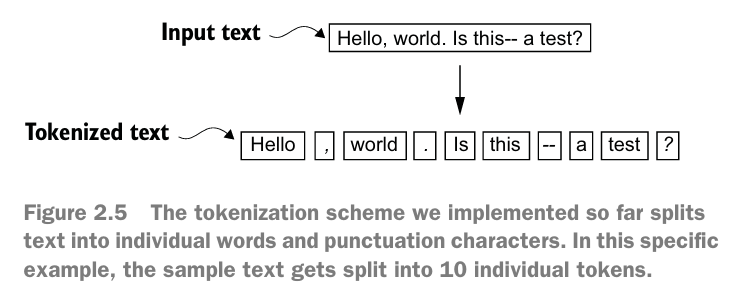

Agora que temos um tokenizador básico funcionando, vamos aplicá-lo a todo o conjunto de Edith Wharton conto:

In [ ]:
# Usa a função 're.split' do módulo 're' para dividir a string 'raw_text'.
# 'raw_text' contém o texto completo do conto de Edith Wharton.
# O primeiro argumento é o padrão da expressão regular a ser usada para a divisão.
# r'([,.:;?_!"()\']|--|\s)' busca por:
#   - qualquer um dos caracteres de pontuação dentro dos colchetes (vírgula, ponto, dois pontos, ponto e vírgula, ponto de interrogação, sublinhado, ponto de exclamação, aspas duplas, parênteses, aspas simples).
#   - a sequência de dois hifens (travessão).
#   - caracteres de espaço em branco (espaços, tabs, novas linhas).
# Os parênteses ao redor da expressão regular fazem com que os delimitadores também sejam incluídos na lista resultante.
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)

# Cria uma nova lista chamada 'preprocessed' removendo os itens que são apenas espaços em branco após a limpeza.
# A list comprehension itera sobre cada 'item' na lista 'preprocessed' original.
# Para cada 'item', o método '.strip()' remove espaços em branco do início e fim.
# 'if item.strip()' verifica se o item não está vazio após a remoção de espaços em branco.
preprocessed = [item.strip() for item in preprocessed if item.strip()]

# Imprime o número de elementos na lista 'preprocessed'.
# Este número representa a quantidade de tokens (palavras e pontuações) resultantes da tokenização do texto completo.
print(len(preprocessed))

4690


Esta instrução print retorna 4690, que é o número de tokens neste texto (sem espaços em branco). Vamos imprimir os primeiros 30 tokens para uma verificação visual rápida:

In [ ]:
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


---

## **2 - Convertendo tokens em IDs de token**

Em seguida, vamos converter esses tokens de uma string Python para uma representação inteira para produzir os IDs dos tokens. Essa conversão é uma etapa intermediária antes de converter os IDs dos tokens em vetores de incorporação.

Para mapear os tokens gerados anteriormente em IDs de tokens, precisamos primeiro construir um vocabulário. Esse vocabulário define como mapeamos cada palavra única e caractere especial para um inteiro único, conforme mostrado na Figura 2.6.

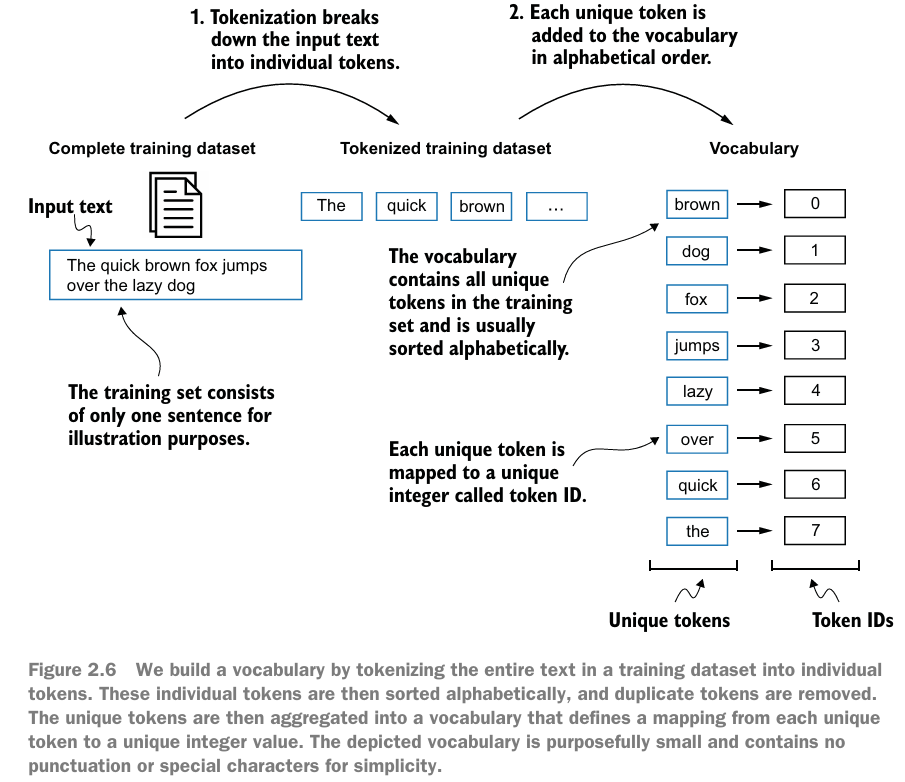

Agora que tokenizamos o conto de Edith Wharton e o atribuímos a uma variável Python chamada `preprocessed`, vamos criar uma lista de todos os tokens exclusivos e classificá-los em ordem alfabética para determinar o tamanho do vocabulário:

In [ ]:
# Cria um conjunto (set) a partir da lista 'preprocessed'.
# Um conjunto contém apenas elementos únicos, removendo quaisquer duplicatas de tokens.
# Em seguida, a função 'sorted()' é usada para classificar os elementos únicos em ordem alfabética.
# O resultado é armazenado na variável 'all_words', que agora contém uma lista de todos os tokens exclusivos e ordenados do texto.
all_words = sorted(set(preprocessed))

# Calcula o tamanho do vocabulário, que é o número de tokens únicos.
# A função 'len()' retorna o número de elementos na lista 'all_words'.
# O resultado é armazenado na variável 'vocab_size'.
vocab_size = len(all_words)

# Imprime o tamanho do vocabulário calculado.
# Isso mostra quantos tokens únicos (palavras e pontuações) existem no texto após a tokenização.
print(vocab_size)

1130


Depois de determinar que o tamanho do vocabulário é 1.130 por meio desse código, criamos o vocabulário e imprimimos suas primeiras 51 entradas para fins ilustrativos.

In [ ]:
# Cria um dicionário chamado 'vocab' que mapeia cada token único para um ID inteiro.
# Isso é feito usando uma dictionary comprehension (compreensão de dicionário).
# 'enumerate(all_words)' itera sobre a lista 'all_words', gerando pares de (índice, valor).
# O índice (integer) se torna a chave e o valor (token) se torna o valor no dicionário.
# Assim, cada token único de 'all_words' recebe um ID inteiro único com base em sua posição ordenada.
vocab = {token:integer for integer,token in enumerate(all_words)}

# Itera sobre os primeiros 51 itens do dicionário 'vocab' para imprimi-los.
# 'vocab.items()' retorna uma visão dos pares chave-valor (token-ID) do dicionário.
# 'enumerate(vocab.items())' adiciona um contador (i) a cada par.
# O loop continua enquanto o índice 'i' for menor ou igual a 50.
for i, item in enumerate(vocab.items()):
   # Imprime o par token-ID atual.
   print(item)
   # Verifica se o índice atingiu 50.
   if i >= 50:
    # Se atingir 50, o loop é interrompido para imprimir apenas os primeiros 51 itens.
    break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


Como podemos ver, o dicionário contém tokens individuais associados a rótulos inteiros exclusivos. Nosso próximo objetivo é aplicar esse vocabulário para converter novos textos em IDs de token (figura 2.7).

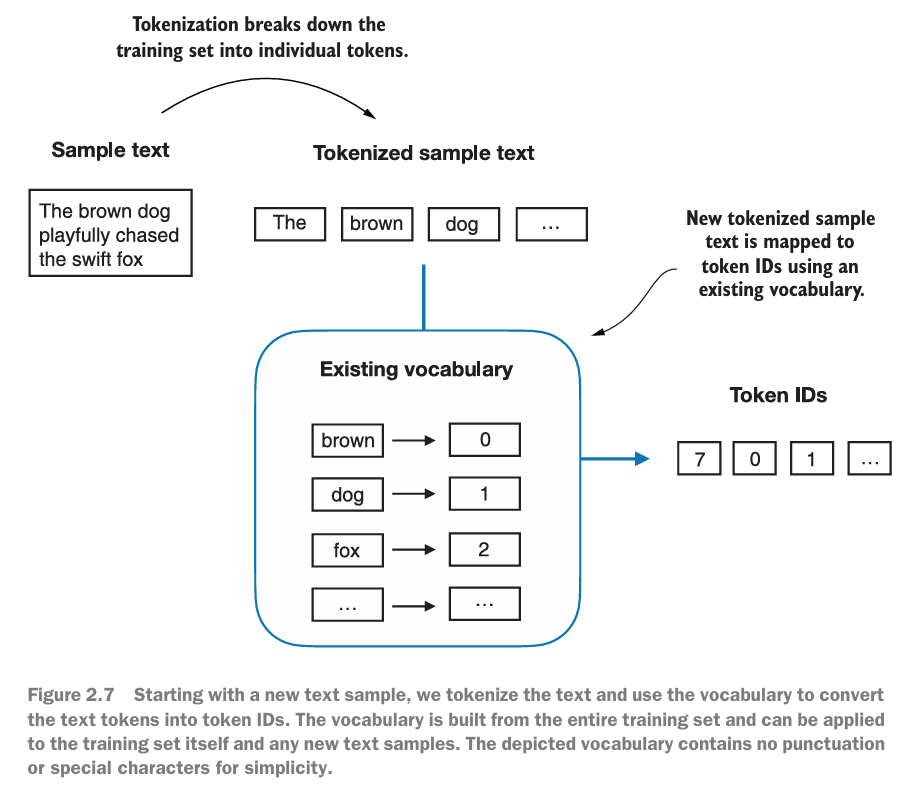

Quando queremos converter as saídas de um LLM de números de volta para texto, precisamos de uma maneira de transformar IDs de token em texto. Para isso, podemos criar uma versão inversa do vocabulário que mapeia os IDs de token de volta para os tokens de texto correspondentes.

Vamos implementar uma classe tokenizadora completa em Python com um método encode que divide o texto em tokens e realiza o mapeamento de string para inteiro para produzir IDs de token por meio do vocabulário. Além disso, implementaremos um método decode que realiza o mapeamento reverso de inteiro para string para converter os IDs de token de volta para texto. A listagem a seguir mostra o código para esta implementação do tokenizador.

In [ ]:
# Define uma classe chamada SimpleTokenizerV1 para realizar a tokenização e a conversão entre texto e IDs de token.
class SimpleTokenizerV1:
   # O método __init__ é o construtor da classe. Ele é chamado quando um novo objeto SimpleTokenizerV1 é criado.
   # Ele recebe um dicionário 'vocab' como argumento.
   def __init__(self, vocab):
       # Cria um dicionário 'str_to_int' que mapeia strings (tokens) para inteiros (IDs de token).
       # Ele armazena o dicionário 'vocab' fornecido, que já deve conter esse mapeamento.
       self.str_to_int = vocab
       # Cria um dicionário 'int_to_str' que mapeia inteiros (IDs de token) para strings (tokens).
       # Isso é feito invertendo o dicionário 'vocab' usando uma dictionary comprehension.
       self.int_to_str = {i:s for s,i in vocab.items()}

   # O método 'encode' recebe uma string de texto e a converte em uma lista de IDs de token.
   def encode(self, text):
       # Divide o texto em tokens usando uma expressão regular.
       # A expressão regular r'([,.?_!"()\']|--|\s)' divide o texto por caracteres de pontuação comuns, travessões (--) e espaços em branco (\s).
       # Os parênteses ao redor da expressão garantem que os delimitadores também sejam incluídos na lista resultante.
       preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
       # Filtra a lista 'preprocessed' para remover elementos que são apenas espaços em branco após remover espaços em branco do início e fim.
       preprocessed = [
           item.strip() for item in preprocessed if item.strip()
       ]
       # Converte cada token na lista 'preprocessed' para seu ID inteiro correspondente usando o dicionário 'str_to_int'.
       # O resultado é uma lista de IDs de token.
       ids = [self.str_to_int[s] for s in preprocessed]
       # Retorna a lista de IDs de token.
       return ids

   # O método 'decode' recebe uma lista de IDs de token e a converte de volta em uma string de texto.
   def decode(self, ids):
        # Converte cada ID de token na lista 'ids' de volta para seu token de string correspondente usando o dicionário 'int_to_str'.
        # Os tokens são então unidos em uma única string, separados por espaços.
        text = " ".join([self.int_to_str[i] for i in ids])

        # Usa uma expressão regular para remover espaços extras que foram adicionados antes de caracteres de pontuação.
        # r'\s+([,.?!"()\'])' busca por um ou mais espaços (\s+) seguidos por um caractere de pontuação (grupo 1).
        # r'\1' substitui a correspondência apenas pelo grupo 1 (o caractere de pontuação), removendo os espaços.
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        # Retorna a string de texto reconstruída.
        return text

Usando a classe Python `SimpleTokenizerV1`, agora podemos instanciar novos objetos tokenizadores por meio de um vocabulário existente, que podemos usar para codificar e decodificar texto, conforme ilustrado na figura 2.8.

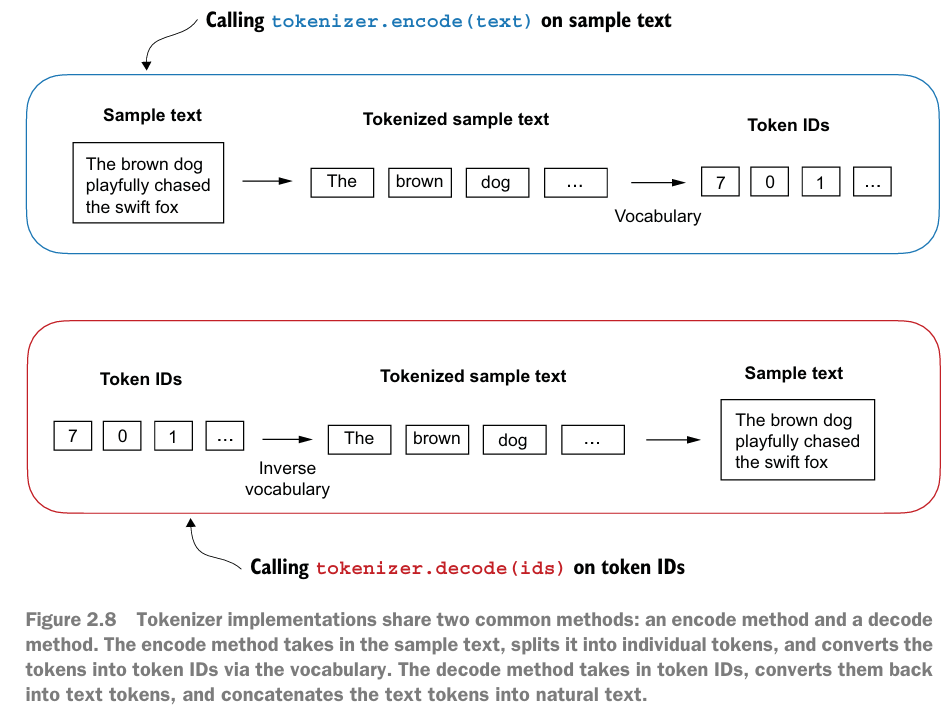

Vamos instanciar um novo objeto tokenizador da classe `SimpleTokenizerV1` e tokenizar um trecho do conto de Edith Wharton para testá-lo na prática:

In [ ]:
# Instancia um novo objeto da classe SimpleTokenizerV1.
# O construtor da classe (.__init__) recebe o dicionário 'vocab' como argumento.
# Este dicionário 'vocab' foi criado anteriormente e mapeia tokens de texto para IDs inteiros únicos.
# O objeto 'tokenizer' criado agora possui os mapeamentos necessários para codificar e decodificar texto.
tokenizer = SimpleTokenizerV1(vocab)

# Define uma string de texto de exemplo a ser tokenizada.
# Este é um trecho do conto de Edith Wharton.
# Aspas triplas são usadas para permitir que a string contenha aspas duplas.
text = """"It's the last he painted, you know,"
      Mrs. Gisburn said with pardonable pride."""

# Chama o método 'encode' do objeto 'tokenizer'.
# O método 'encode' recebe a string 'text' como entrada.
# Ele processa a string, dividindo-a em tokens (palavras e pontuações) usando a lógica de expressão regular definida na classe.
# Em seguida, ele usa o dicionário 'str_to_int' (que é o 'vocab') para converter cada token em seu ID inteiro correspondente.
# O resultado é uma lista de IDs de token que representa a string de texto original.
ids = tokenizer.encode(text)

# Imprime a lista de IDs de token gerada pelo método 'encode'.
# Esta lista é a representação numérica do texto de exemplo após a tokenização.
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


Vamos ver se podemos transformar esses IDs de token novamente em texto usando o método de decodificação:

In [ ]:
# Chama o método 'decode' do objeto 'tokenizer'.
# O método 'decode' recebe uma lista de IDs de token ('ids') como entrada.
# Ele usa o dicionário 'int_to_str' (que foi criado no construtor da classe SimpleTokenizerV1, invertendo o vocabulário)
# para converter cada ID de token de volta para seu token de string correspondente.
# Em seguida, ele junta esses tokens de string para reconstruir o texto original.
# Qualquer espaço em branco extra adicionado antes da pontuação durante a codificação é removido para formar uma string de texto legível.
# O objetivo deste método é reverter o processo de tokenização, convertendo a representação numérica (IDs) de volta para a representação textual.
print(tokenizer.decode(ids))

" It' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.


Implementamos um tokenizador capaz de tokenizar e destokenizar texto com base em um trecho do conjunto de treinamento. Vamos agora aplicá-lo a uma nova amostra de texto não contida no conjunto de treinamento:

In [ ]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

O problema é que a palavra "Hello" não foi usada no conto "The Verdict". Portanto, ela não está presente no vocabulário. Isso destaca a necessidade de considerar conjuntos de treinamento amplos e diversificados para ampliar o vocabulário ao trabalhar em LLMs.

Em seguida, testaremos o tokenizador mais detalhadamente em textos que contêm palavras desconhecidas e discutiremos tokens especiais adicionais que podem ser usados para fornecer mais contexto para um LLM durante o treinamento.

---

## **3 - Adicionando tokens de contexto especiais**

Precisamos modificar o tokenizador para lidar com palavras desconhecidas. Também precisamos abordar o uso e a adição de tokens de contexto especiais que podem aprimorar a compreensão do contexto ou de outras informações relevantes no texto por um modelo. Esses tokens especiais podem incluir marcadores para palavras desconhecidas e limites de documentos, por exemplo. Em particular, modificaremos o vocabulário e o tokenizador, `SimpleTokenizerV2`, para suportar dois novos tokens, `<|unk|>` e `<|endoftext|>`, conforme ilustrado na Figura 2.9.

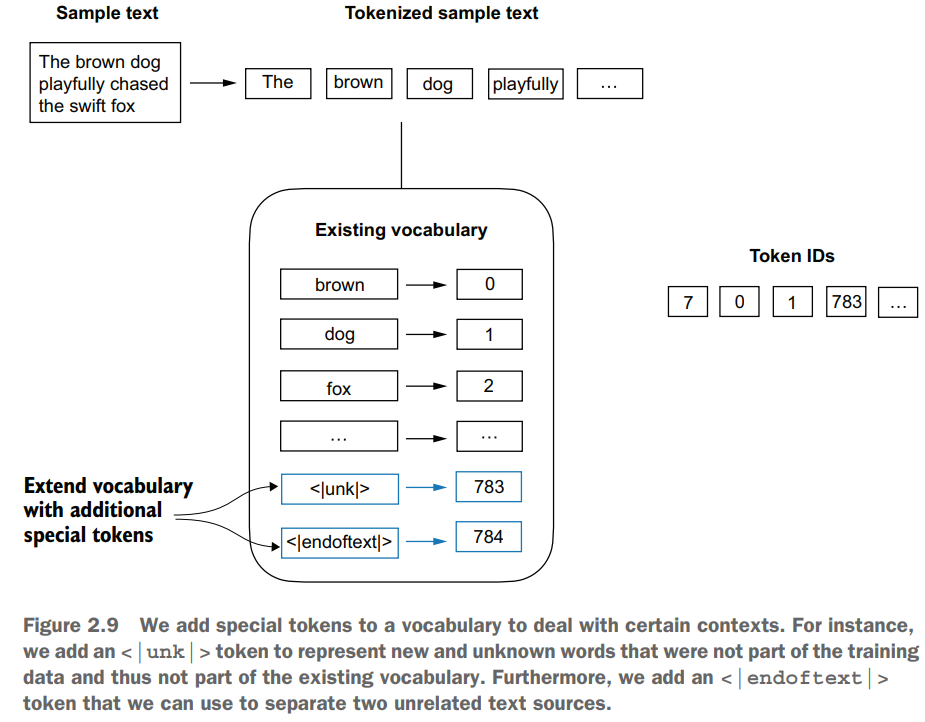

Podemos modificar o tokenizador para usar um token `<|unk|>` caso encontre uma palavra que não faça parte do vocabulário. Além disso, adicionamos um token entre textos não relacionados. Por exemplo, ao treinar LLMs do tipo GPT em vários documentos ou livros independentes, é comum inserir um token antes de cada documento ou livro que segue uma fonte de texto anterior, como ilustrado na Figura 2.10. Isso ajuda o LLM a entender que, embora essas fontes de texto estejam concatenadas para treinamento, elas, na verdade, não são relacionadas.

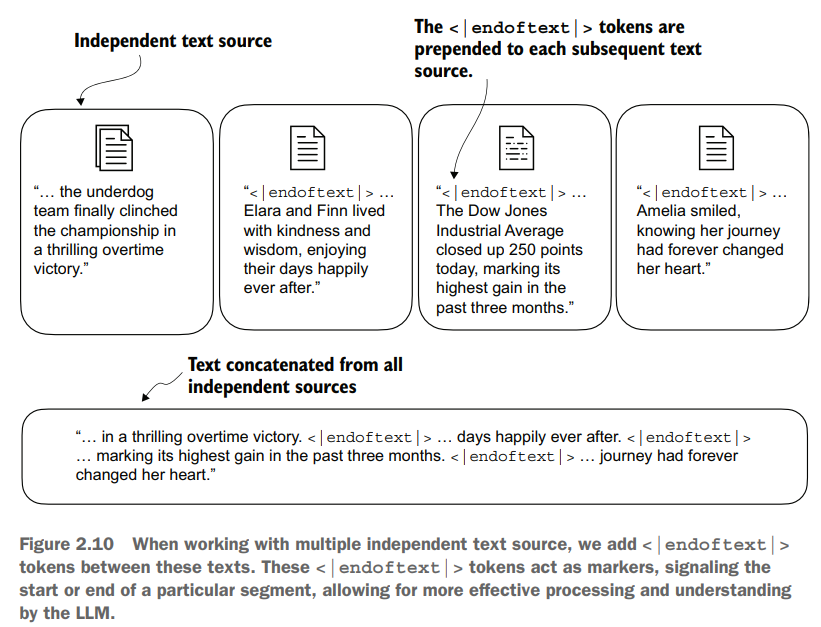

Vamos agora modificar o vocabulário para incluir esses dois tokens especiais, `<|unk|>` e `<|endoftext|>`, adicionando-os à nossa lista de todas as palavras únicas:

In [ ]:
# Cria uma lista chamada 'all_tokens'.
# Primeiro, um conjunto (set) é criado a partir da lista 'preprocessed'. Isso remove tokens duplicados, garantindo que cada token apareça apenas uma vez.
# Em seguida, o conjunto é convertido de volta para uma lista usando list().
# Finalmente, a lista é classificada em ordem alfabética usando sorted().
# O resultado é uma lista de todos os tokens únicos e ordenados do texto original.
all_tokens = sorted(list(set(preprocessed)))

# Adiciona os tokens especiais "<|endoftext|>" e "<|unk|>" à lista 'all_tokens'.
# O método .extend() é usado para adicionar os elementos da lista fornecida ao final da lista 'all_tokens'.
# "<|endoftext|>" é um token especial que pode ser usado para marcar o final de um documento ou seção de texto.
# "<|unk|>" (unknown) é um token especial usado para representar palavras ou símbolos que não estão no vocabulário.
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

# Cria um dicionário chamado 'vocab' que mapeia cada token (string) para um ID inteiro único.
# Uma dictionary comprehension é usada para construir o dicionário.
# enumerate(all_tokens) itera sobre a lista 'all_tokens', gerando pares (índice, valor). O índice começa em 0.
# Para cada par (integer, token), o 'token' se torna a chave e o 'integer' (o índice) se torna o valor no dicionário 'vocab'.
# Isso cria um mapeamento único de cada token na lista 'all_tokens' (incluindo os tokens especiais) para um ID inteiro.
vocab = {token:integer for integer,token in enumerate(all_tokens)}

# Imprime o número total de itens no dicionário 'vocab'.
# len(vocab.items()) retorna o número de pares chave-valor no dicionário.
# Isso representa o tamanho final do vocabulário, incluindo os tokens especiais.
print(len(vocab.items()))

1132


O novo tamanho do vocabulário é 1.132 (o tamanho do vocabulário anterior era 1.130). Como uma verificação rápida adicional, vamos imprimir as últimas cinco entradas do vocabulário atualizado:

In [ ]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


Com base na saída do código, podemos confirmar que os dois novos tokens especiais foram de fato incorporados com sucesso ao vocabulário. Em seguida, ajustamos o tokenizador da classe `SimpleTokenizerV1` conforme mostrado no código a seguir.

In [ ]:
class SimpleTokenizerV2:
    # O método __init__ é o construtor da classe. Ele é chamado quando um novo objeto SimpleTokenizerV2 é criado.
    # Ele recebe um dicionário 'vocab' como argumento, que contém o mapeamento de tokens para IDs.
    def __init__(self, vocab):
        # Armazena o dicionário de mapeamento de string para inteiro (token para ID) fornecido no vocabulário.
        self.str_to_int = vocab
        # Cria um dicionário de mapeamento inverso de inteiro para string (ID para token) a partir do vocabulário.
        self.int_to_str = { i:s for s,i in vocab.items()}

    # O método 'encode' recebe uma string de texto e a converte em uma lista de IDs de token.
    # Parâmetros:
    # - text: A string de texto a ser codificada.
    # Resultados:
    # - Uma lista de IDs inteiros representando o texto de entrada.
    def encode(self, text):
        # Divide o texto em tokens usando uma expressão regular que considera pontuações, travessões e espaços em branco como delimitadores.
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        # Remove elementos da lista que são apenas espaços em branco após remover espaços do início e fim.
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        # Substitui tokens que não estão no vocabulário pelo token especial "<|unk|>".
        preprocessed = [item if item in self.str_to_int
                        else "<|unk|>" for item in preprocessed]
        # Converte cada token (agora garantido de estar no vocabulário ou ser "<|unk|>") para seu ID inteiro correspondente usando o dicionário str_to_int.
        ids = [self.str_to_int[s] for s in preprocessed]
        # Retorna a lista de IDs de token.
        return ids

    # O método 'decode' recebe uma lista de IDs de token e a converte de volta em uma string de texto.
    # Parâmetros:
    # - ids: Uma lista de IDs de token inteiros.
    # Resultados:
    # - Uma string de texto reconstruída a partir dos IDs de token.
    def decode(self, ids):
        # Converte cada ID de token de volta para seu token de string correspondente usando o dicionário int_to_str e junta os tokens com espaços.
        text = " ".join([self.int_to_str[i] for i in ids])
        # Usa uma expressão regular para limpar espaços extras que foram adicionados antes de caracteres de pontuação durante a junção.
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        # Retorna a string de texto decodificada.
        return text

Em comparação com o `SimpleTokenizerV1` que implementamos na Listagem 2.3, o novo SimpleTokenizerV2 substitui palavras desconhecidas por tokens `<|unk|>`.

Vamos agora testar este novo tokenizador na prática. Para isso, usaremos um exemplo de texto simples que concatenamos a partir de duas frases independentes e não relacionadas:

In [ ]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [ ]:
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]


Podemos ver que a lista de IDs de token contém `1130` para o token separador `<|endoftext|>`, bem como dois tokens `1131`, que são usados para palavras desconhecidas.

Vamos destokenizar o texto para uma rápida verificação de integridade:

In [ ]:
print(tokenizer.decode(tokenizer.encode(text)))

<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


Com base na comparação deste texto destokenizado com o texto de entrada original, sabemos que o conjunto de dados de treinamento, o conto de Edith Wharton “O Veredito”, não contém as palavras “*Hello*” e “*palace*”.

---

## **4 - Codificação de pares de bytes**

Vamos analisar um esquema de tokenização mais sofisticado baseado em um conceito chamado codificação de pares de bytes (BPE). O tokenizador BPE foi usado para treinar LLMs como GPT-2, GPT-3 e o modelo original usado no ChatGPT.

Como implementar BPE pode ser relativamente complexo, usaremos uma biblioteca Python de código aberto existente chamada [tiktoken](https://github.com/openai/tiktoken), que implementa o algoritmo BPE de forma muito eficiente com base no código-fonte em Rust.

In [ ]:
#!pip uninstall tiktoken -y

In [ ]:
!pip install tiktoken==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.11.0
    Uninstalling tiktoken-0.11.0:
      Successfully uninstalled tiktoken-0.11.0


O código que usaremos é baseado no TikTok 0.7.0. Você pode usar o seguinte código para verificar a versão que você tem instalada atualmente:

In [ ]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.7.0


Uma vez instalado, podemos instanciar o tokenizador BPE do tiktoken da seguinte maneira:

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

O uso deste tokenizador é semelhante ao `SimpleTokenizerV2` que implementamos anteriormente por meio de um método encode:

In [ ]:
# Define a string de texto a ser tokenizada.
# Esta string contém duas frases separadas pelo token especial "<|endoftext|>".
# Note que a palavra "someunknownPlace" é intencionalmente escrita sem espaço
# para ver como o tokenizador BPE lida com ela.
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
    " of someunknownPlace."
)

# Utiliza o tokenizador 'tokenizer' (instanciado anteriormente como um tokenizador BPE do tiktoken, modelo gpt2)
# para codificar a string de texto em uma lista de IDs de token (inteiros).
# O parâmetro 'allowed_special={"<|endoftext|>"}' informa ao tokenizador para
# tratar "<|endoftext|>" como um token especial válido e não como uma sequência de caracteres normal.
# O resultado da codificação é uma lista de inteiros que representam o texto de entrada.
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

# Imprime a lista de IDs de token gerada pelo método encode.
# Esta lista mostra a representação numérica do texto após a tokenização BPE.
print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


Podemos então converter os IDs dos tokens novamente em texto usando o método de decodificação, semelhante ao nosso `SimpleTokenizerV2`:

In [ ]:
strings = tokenizer.decode(integers)
print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [ ]:
# Itera sobre a lista de IDs de token gerada anteriormente.
for id in integers:
    # Decodifica cada ID individual de volta para sua representação de string usando o tokenizador.
    token_string = tokenizer.decode([id])
    # Imprime o ID (inteiro) e o token de string correspondente lado a lado.
    print(f"{id}: {token_string}")

15496: Hello
11: ,
466:  do
345:  you
588:  like
8887:  tea
30: ?
220:  
50256: <|endoftext|>
554:  In
262:  the
4252:  sun
18250: lit
8812:  terr
2114: aces
286:  of
617:  some
34680: unknown
27271: Place
13: .


Podemos fazer duas observações dignas de nota com base nos IDs dos tokens e no texto decodificado. Primeiro, o token `<|endoftext|>` recebe um ID de token relativamente grande, ou seja, 50256. De fato, o tokenizador BPE, que foi usado para treinar modelos como GPT-2, GPT-3 e o modelo original usado no ChatGPT, tem um vocabulário total de 50.257, sendo `<|endoftext|>` o maior ID de token atribuído.

Segundo, o tokenizador BPE codifica e decodifica palavras desconhecidas, como
`someunknownPlacem`, corretamente. O tokenizador BPE pode lidar com qualquer palavra desconhecida. Como ele consegue isso sem usar tokens `<|unk|>`?

O algoritmo subjacente ao BPE divide palavras que não estão em seu vocabulário predefinido em unidades menores de subpalavras ou até mesmo caracteres individuais, permitindo que ele trate palavras fora do vocabulário. Assim, graças ao algoritmo BPE, se o tokenizador encontrar uma palavra desconhecida durante a tokenização, ele poderá representá-la como uma sequência de tokens ou caracteres de subpalavra, conforme ilustrado na figura 2.11.

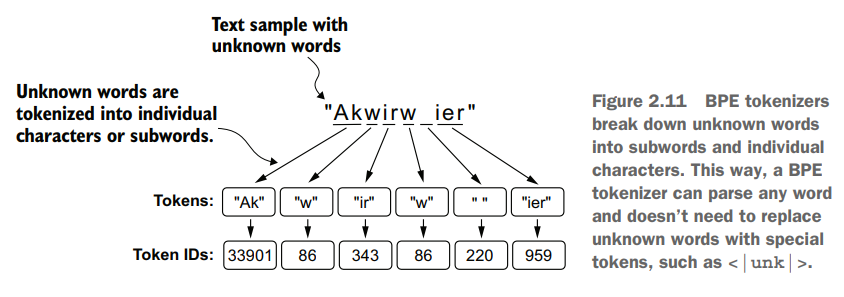

A capacidade de dividir palavras desconhecidas em caracteres individuais garante que o tokenizador e, consequentemente, o LLM treinado com ele possam processar qualquer texto, mesmo que contenha palavras que não estavam presentes em seus dados de treinamento.

## **5 - Amostragem de dados com janela deslizante**

O próximo passo na criação dos embeddings para o LLM é gerar os pares entrada-alvo necessários para o treinamento de um LLM. Como são esses pares entrada-alvo? Como já aprendemos, os LLMs são pré-treinados pela previsão da próxima palavra em um texto, conforme ilustrado na figura 2.12.

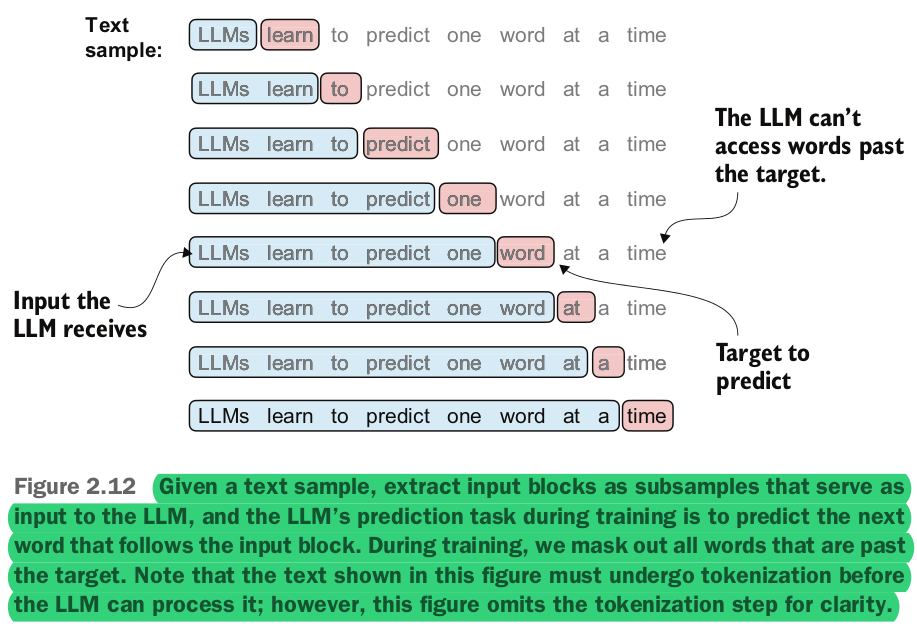

Vamos implementar um carregador de dados que busca os pares de entrada-alvo da Figura 2.12 no conjunto de dados de treinamento usando uma abordagem de janela deslizante. Para começar, tokenizaremos toda a história resumida "O Veredito" usando o tokenizador BPE:

In [ ]:
with open("the-veredict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


Em seguida, removemos os primeiros 50 tokens do conjunto de dados para fins de demonstração, pois isso resulta em uma passagem de texto um pouco mais interessante nas próximas etapas:

In [ ]:
enc_sample = enc_text[50:]

Uma das maneiras mais fáceis e intuitivas de criar os pares de entrada-alvo para a tarefa de previsão da próxima palavra é criar duas variáveis, $x$ e $y$, onde $x$ contém os tokens de entrada e $y$ contém os alvos, que são as entradas deslocadas em 1:

In [ ]:
# Define o tamanho da janela de contexto.
# Este valor determina quantos tokens anteriores serão usados como entrada para prever o próximo token.
context_size = 4

# Cria a sequência de entrada 'x'.
# Ela pega uma fatia da lista 'enc_sample' (que contém os IDs de token do texto)
# do início até o índice especificado por 'context_size' (não inclusivo).
# Portanto, 'x' conterá os primeiros 'context_size' tokens.
x = enc_sample[:context_size]

# Cria a sequência alvo 'y'.
# Ela pega uma fatia da lista 'enc_sample' a partir do índice 1
# até o índice especificado por 'context_size + 1' (não inclusivo).
# Isso efetivamente desloca a sequência de 'x' em um token para a direita.
# Assim, para cada token em 'x', o token correspondente em 'y' é o próximo token na sequência original.
y = enc_sample[1:context_size+1]

# Imprime a sequência de entrada 'x'.
print(f"x: {x}")

# Imprime a sequência alvo 'y'.
# A formatação com espaços ('      ') é usada para alinhar a saída 'y' visualmente
# com a saída 'x', destacando o deslocamento de um token.
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


Ao processar as entradas junto com os alvos, que são as entradas deslocadas em uma posição, podemos criar as tarefas de previsão da próxima palavra (veja a figura 2.12), da seguinte forma:

In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


Tudo à esquerda da seta (`---->`) refere-se à entrada que um LLM receberia, e o ID do token à direita da seta representa o ID do token de destino que o LLM deve prever. Vamos repetir o código anterior, mas converter os IDs dos tokens em texto:

In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


Resta apenas mais uma tarefa antes de transformarmos os tokens em embeddings: implementar um carregador de dados eficiente que itere sobre o conjunto de dados de entrada e retorne as entradas e os alvos como tensores PyTorch, que podem ser considerados matrizes multidimensionais. Em particular, estamos interessados em retornar dois tensores: um tensor de entrada contendo o texto que o LLM vê e um tensor de alvo que inclui os alvos para o LLM prever, conforme ilustrado na figura 2.13. Embora a figura mostre os tokens em formato de string para fins ilustrativos, a implementação do código operará diretamente nos IDs de token, já que o método encode do tokenizador BPE realiza tanto a tokenização quanto a conversão em IDs de token em uma única etapa.

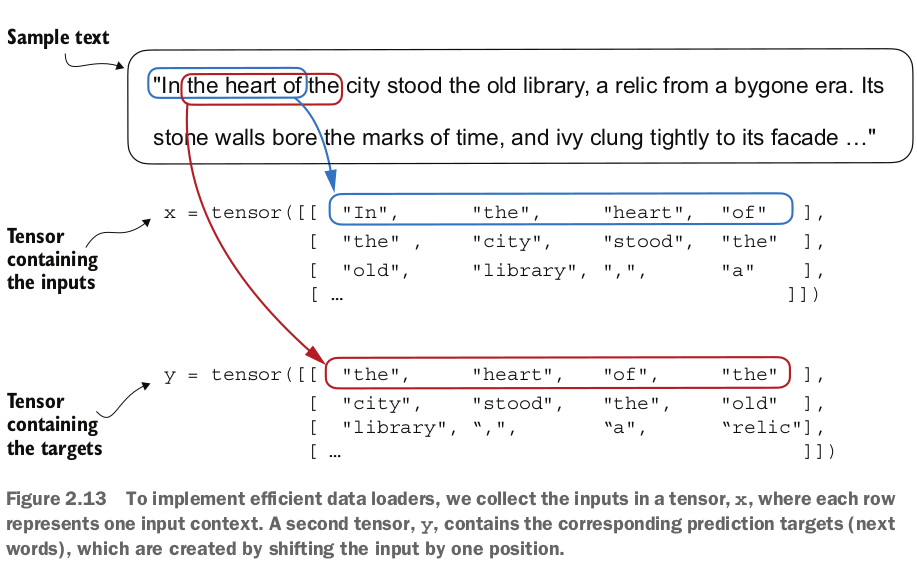

**NOTA: Para uma implementação eficiente do carregador de dados, usaremos as classes `Dataset` e `DataLoader` integradas do PyTorch. Para obter mais informações e orientações sobre a instalação do PyTorch, consulte a seção A.2.1.3 no apêndice A.**

In [ ]:
# Importa a biblioteca principal do PyTorch.
# PyTorch é uma estrutura de aprendizado de máquina de código aberto usada para construir e treinar redes neurais.
import torch

# Importa as classes Dataset e DataLoader do submódulo utils.data do PyTorch.
# - Dataset: Uma classe abstrata que representa um conjunto de dados. Classes de conjunto de dados personalizadas herdam desta classe e implementam os métodos __len__ e __getitem__.
# - DataLoader: Um iterador que fornece dados de um Dataset em lotes (batches). Ele lida com embaralhamento, amostragem e paralelismo para carregar os dados de forma eficiente para o treinamento do modelo.
from torch.utils.data import Dataset, DataLoader

In [ ]:
class GPTDatasetV1(Dataset):
    # O método __init__ é o construtor da classe.
    # Ele recebe o texto (txt), o tokenizador, o comprimento máximo da sequência (max_length) e o passo da janela deslizante (stride).
    def __init__(self, txt, tokenizer, max_length, stride):
        # Inicializa listas vazias para armazenar os IDs dos tokens de entrada.
        self.input_ids = []
        # Inicializa listas vazias para armazenar os IDs dos tokens alvo.
        self.target_ids = []

        # Codifica o texto de entrada (txt) em uma lista de IDs de token usando o tokenizador fornecido.
        token_ids = tokenizer.encode(txt)

        # Itera sobre a lista de IDs de token com um passo definido (stride).
        # O loop começa no índice 0 e vai até o final da lista 'token_ids',
        # subtraindo 'max_length' para garantir que haja tokens suficientes para a janela.
        for i in range(0, len(token_ids) - max_length, stride):
            # Extrai a sequência de IDs de token para a entrada ('input_chunk').
            # Esta sequência começa no índice 'i' e tem o comprimento 'max_length'.
            input_chunk = token_ids[i:i + max_length]
            # Extrai a sequência de IDs de token para o alvo ('target_chunk').
            # Esta sequência começa no índice 'i + 1' e tem o comprimento 'max_length'.
            # Isso cria os pares entrada-alvo deslocados em um token.
            target_chunk = token_ids[i + 1: i + max_length + 1]
            # Converte a sequência de entrada para um tensor PyTorch e a anexa à lista input_ids.
            self.input_ids.append(torch.tensor(input_chunk))
            # Converte a sequência alvo para um tensor PyTorch e a anexa à lista target_ids.
            self.target_ids.append(torch.tensor(target_chunk))

    # O método __len__ retorna o número total de amostras no conjunto de dados.
    # O número de amostras é igual ao número de sequências de entrada/alvo armazenadas.
    def __len__(self):
        return len(self.input_ids)

    # O método __getitem__ recupera uma amostra específica do conjunto de dados dado um índice (idx).
    # Ele retorna o par entrada-alvo correspondente como tensores PyTorch.
    def __getitem__(self, idx):
        # Retorna o tensor de entrada no índice especificado e o tensor alvo correspondente.
        return self.input_ids[idx], self.target_ids[idx]

A classe `GPTDatasetV1` é baseada na classe `Dataset` do PyTorch e define como linhas individuais são obtidas do conjunto de dados, onde cada linha consiste em um número de IDs de token (com base em um `max_length`) atribuídos a um tensor `input_chunk`. O tensor `target_chunk` contém os alvos correspondentes. Recomendo continuar lendo para ver como ficam os dados retornados deste conjunto de dados quando combinamos o conjunto de dados com um `DataLoader` do PyTorch — isso trará mais intuição e clareza.

**NOTA: Se você não conhece a estrutura das classes `Dataset` do PyTorch, como mostrado na Listagem 2.5, consulte a seção A.6 no apêndice A, que explica a estrutura geral e o uso das classes `Dataset` e `DataLoader` do PyTorch.**

O código a seguir usa o `GPTDatasetV1` para carregar as entradas em lotes por meio de um `DataLoader` do PyTorch.

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                        stride=128, shuffle=True, drop_last=True,
                        num_workers=0):
    """
    Cria e configura um DataLoader para carregar dados de texto para treinamento de LLM.

    Esta função orquestra o processo de preparação de dados:
    1. Inicializa um tokenizador para converter texto em IDs numéricos.
    2. Cria um Dataset customizado que processa o texto tokenizado em pares de entrada-alvo
       usando uma janela deslizante.
    3. Configura um DataLoader para carregar esses pares de entrada-alvo em lotes,
       prontos para serem alimentados em um modelo de LLM.

    Parâmetros:
    - txt (str): O texto de entrada completo a ser processado.
    - batch_size (int, opcional): O número de amostras por lote retornado pelo DataLoader.
                                 Padrão é 4.
    - max_length (int, opcional): O comprimento máximo da sequência de tokens para cada entrada
                                  e alvo no Dataset. Isso define o tamanho da janela deslizante.
                                  Padrão é 256.
    - stride (int, opcional): O número de tokens para "pular" ao mover a janela deslizante
                              pelo texto. Um stride menor (e.g., 1) resulta em mais sobreposição
                              entre as amostras e mais dados de treinamento; um stride maior
                              (e.g., igual a max_length) significa janelas não sobrepostas.
                              Padrão é 128.
    - shuffle (bool, opcional): Se True, embaralha os dados a cada época de treinamento.
                                Isso ajuda a evitar que o modelo aprenda a ordem das amostras.
                                Padrão é True.
    - drop_last (bool, opcional): Se True, descarta o último lote se o seu tamanho for menor
                                 que batch_size. Isso garante que todos os lotes tenham o mesmo
                                 tamanho, o que pode simplificar o código de treinamento.
                                 Padrão é True.
    - num_workers (int, opcional): O número de subprocessos a serem usados para carregar dados.
                                  Usar múltiplos workers pode acelerar o carregamento de dados,
                                  mas 0 significa que o carregamento é feito no processo principal.
                                  Padrão é 0.

    Resultados:
    - dataloader (torch.utils.data.DataLoader): Um objeto DataLoader configurado que pode
                                               ser iterado para obter lotes de tensores
                                               (entrada, alvo) para treinamento.
    """
    # 1. Inicialização do Tokenizador:
    #    Obtém um tokenizador BPE pré-treinado do modelo "gpt2" usando a biblioteca tiktoken.
    #    Este tokenizador é otimizado para modelos como GPT-2 e GPT-3 e lida eficientemente
    #    com a conversão de texto em sequências de IDs numéricos (tokens).
    #    Ele é essencial para transformar o texto bruto em um formato que o modelo pode processar.
    tokenizer = tiktoken.get_encoding("gpt2")

    # 2. Criação do Dataset Customizado:
    #    Instancia a classe GPTDatasetV1, passando o texto de entrada, o tokenizador,
    #    o comprimento máximo da sequência e o passo da janela.
    #    O Dataset é responsável por:
    #    - Tokenizar o texto completo.
    #    - Aplicar a lógica de janela deslizante para criar múltiplos pares (entrada, alvo)
    #      a partir do texto tokenizado. Cada 'entrada' é uma sequência de 'max_length' tokens,
    #      e o 'alvo' é a mesma sequência deslocada em um token para a direita.
    #    - Armazenar esses pares como tensores PyTorch.
    #    Cada item no Dataset (obtido via __getitem__) será um par de tensores (entrada, alvo).
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # 3. Configuração do DataLoader:
    #    Cria o DataLoader que envolverá o objeto 'dataset'.
    #    O DataLoader automatiza a iteração sobre o Dataset, agrupando amostras em lotes.
    #    - 'dataset': O objeto Dataset do qual o DataLoader irá carregar os dados.
    #    - 'batch_size': Define o número de pares (entrada, alvo) incluídos em cada lote.
    #    - 'shuffle': Se True, a ordem das amostras no Dataset é aleatorizada em cada "época"
    #                 (uma passagem completa por todos os dados), o que é crucial para
    #                 um treinamento robusto do modelo.
    #    - 'drop_last': Garante que todos os lotes retornados pelo DataLoader tenham
    #                   exatamente o tamanho 'batch_size'. Isso é útil para evitar
    #                   problemas de dimensionalidade em algumas arquiteturas de modelo
    #                   e otimizações.
    #    - 'num_workers': Especifica quantos processos paralelos o DataLoader pode usar
    #                     para carregar dados. Valores maiores que 0 podem acelerar
    #                     o carregamento de dados, especialmente em Datasets grandes.
    dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
    )

    # Retorna o DataLoader configurado.
    # Este DataLoader está pronto para ser usado em um loop de treinamento, fornecendo
    # lotes de dados (entrada, alvo) para o modelo.
    return dataloader

Vamos testar o `dataloader` com um tamanho de lote de 1 para um LLM com um tamanho de contexto de 4 para desenvolver uma intuição de como a classe `GPTDatasetV1` da listagem 2.5 e a função `create_dataloader_v1` da listagem 2.6 funcionam juntas:

In [ ]:
# Abre o arquivo de texto "the-verdict.txt" no modo de leitura ('r') com codificação UTF-8.
# O bloco 'with open(...) as f:' garante que o arquivo seja fechado automaticamente.
with open("the-veredict.txt", "r", encoding="utf-8") as f:
    # Lê todo o conteúdo do arquivo e armazena na variável 'raw_text'.
    raw_text = f.read()

# Cria um DataLoader usando a função create_dataloader_v1.
# - raw_text: O texto completo do conto para ser processado.
# - batch_size=1: Define que cada lote de dados terá apenas uma amostra.
# - max_length=4: Define o tamanho da sequência de entrada e alvo para 4 tokens.
# - stride=1: Define o passo da janela deslizante para 1, o que significa que as janelas se sobrepõem bastante.
# - shuffle=False: Desativa o embaralhamento dos dados, para que a ordem das amostras seja fixa.
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)

# Cria um iterador a partir do DataLoader.
# Isso permite percorrer os lotes de dados gerados pelo DataLoader.
data_iter = iter(dataloader)

# Obtém o próximo lote de dados do iterador.
# Como batch_size é 1, 'first_batch' será uma tupla contendo dois tensores PyTorch:
# o primeiro tensor é a entrada (uma sequência de 4 IDs de token) e o segundo é o alvo
# (uma sequência de 4 IDs de token, deslocada em 1 em relação à entrada).
first_batch = next(data_iter)

# Imprime o primeiro lote de dados obtido.
# A saída mostrará os tensores de entrada e alvo para a primeira amostra do dataset.
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


A variável first_batch contém dois tensores: o primeiro tensor armazena os IDs dos tokens de entrada e o segundo tensor armazena os IDs dos tokens de destino. Como `max_length` é definido como 4, cada um dos dois tensores contém quatro IDs de token. Observe que um tamanho de entrada de 4 é bastante pequeno e escolhido apenas por simplicidade. É comum treinar LLMs com tamanhos de entrada de pelo menos 256.

Para entender o significado de `stride=1`, vamos buscar outro lote deste conjunto de dados:

In [ ]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


Se compararmos o primeiro e o segundo lotes, podemos ver que os IDs de token
do segundo lote são deslocados em uma posição (por exemplo, o segundo ID na entrada do primeiro lote é 367, que é o primeiro ID da entrada do segundo lote). A configuração do `stride` determina o número de posições que as entradas deslocam entre os lotes, emulando uma abordagem de janela deslizante, conforme demonstrado na figura 2.14.

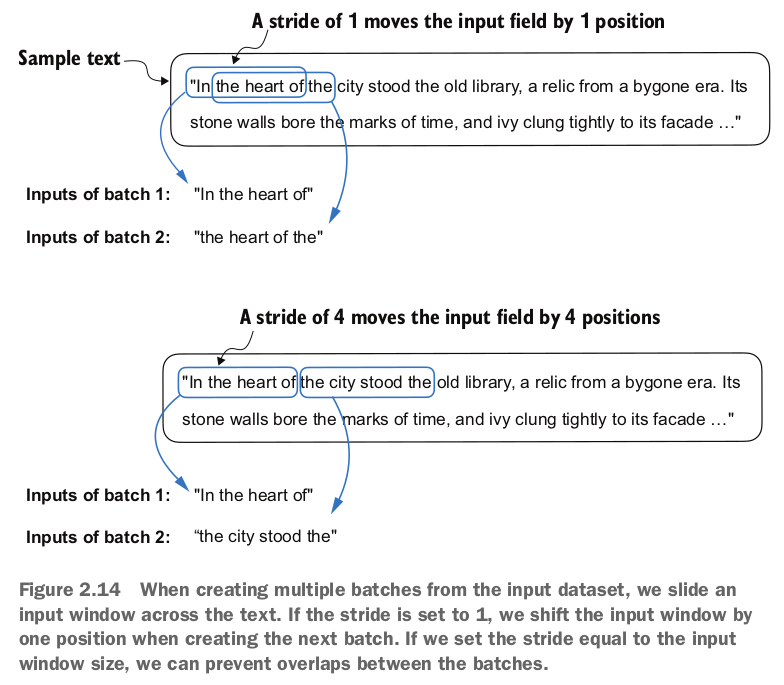

Tamanhos de lote de 1, como os que amostramos do carregador de dados até agora, são úteis para fins ilustrativos. Se você já tem experiência com aprendizado profundo, talvez saiba que tamanhos de lote pequenos exigem menos memória durante o treinamento, mas levam a atualizações de modelo mais ruidosas. Assim como no aprendizado profundo tradicional, o tamanho do lote é uma compensação e um hiperparâmetro a ser experimentado ao treinar LLMs.

Vejamos brevemente como podemos usar o carregador de dados para amostrar com um tamanho de lote
maior que 1:

In [ ]:
# Cria um DataLoader usando a função create_dataloader_v1 com os seguintes parâmetros:
# - raw_text: O texto completo do conto de Edith Wharton.
# - batch_size=8: Define que cada lote de dados conterá 8 amostras. Isso significa que os tensores de entrada e alvo
#                 terão a forma [8, max_length].
# - max_length=4: Define o tamanho da sequência de entrada e alvo para 4 tokens por amostra.
# - stride=4: Define o passo da janela deslizante para 4. Como stride é igual a max_length,
#             as janelas deslizantes não se sobrepõem.
# - shuffle=False: Desativa o embaralhamento dos dados, garantindo que a ordem dos lotes seja fixa para fins de demonstração.
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=4, stride=4,
    shuffle=False
    )

# Cria um iterador a partir do DataLoader.
# Este iterador permitirá obter os lotes de dados gerados pelo DataLoader um por um.
data_iter = iter(dataloader)

# Obtém o próximo (neste caso, o primeiro) lote de dados do iterador.
# Como batch_size é 8, 'next(data_iter)' retornará uma tupla de dois tensores:
# - inputs: Um tensor PyTorch contendo as sequências de entrada para o lote. Sua forma será [8, 4].
# - targets: Um tensor PyTorch contendo as sequências alvo correspondentes para o lote. Sua forma também será [8, 4].
inputs, targets = next(data_iter)

# Imprime o tensor de entradas.
# A saída mostrará 8 linhas, cada uma contendo 4 IDs de token, representando as 8 sequências de entrada no primeiro lote.
print("Inputs:\n", inputs)

# Imprime o tensor de alvos.
# A saída mostrará 8 linhas, cada uma contendo 4 IDs de token. Cada linha de alvos
# é a sequência de entrada correspondente deslocada em um token para a direita.
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


Observe que aumentamos o passo para 4 para utilizar o conjunto de dados completamente (não pulamos uma única palavra). Isso evita qualquer sobreposição entre os lotes, pois mais sobreposição poderia levar a um aumento no **sobreajuste** (overfiting).

---

## **6 - Criação de embeddings de tokens**

A última etapa na preparação do texto de entrada para o treinamento do LLM é converter os IDs dos tokens em vetores de embedding, conforme mostrado na Figura 2.15. Como etapa preliminar, devemos inicializar esses pesos de embedding com valores aleatórios. Essa inicialização serve como ponto de partida para o processo de aprendizado do LLM. No Capítulo 5, otimizaremos os pesos de embedding como parte do treinamento do LLM.

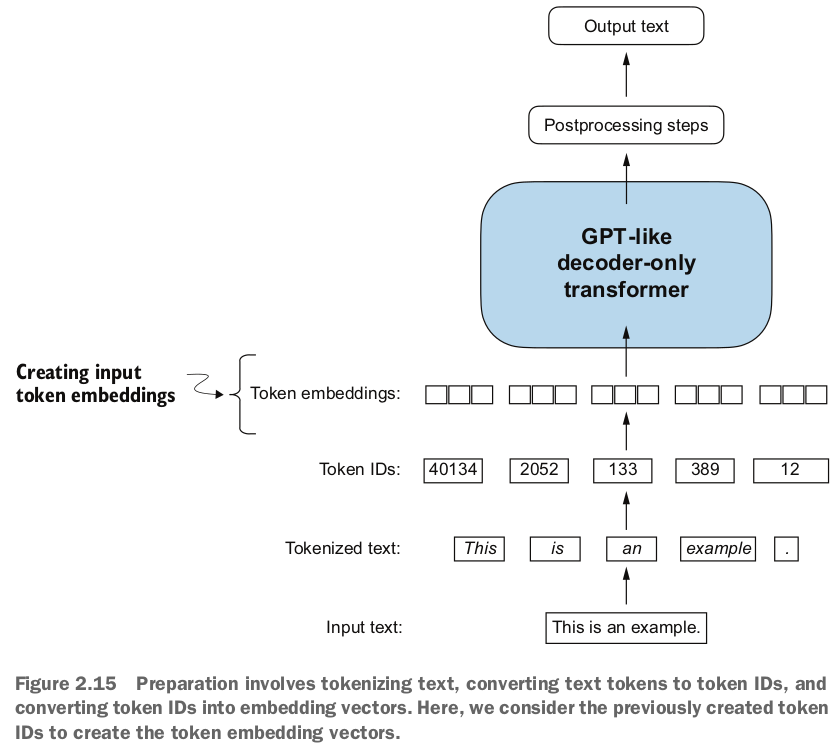

Uma representação vetorial contínua, ou embedding, é necessária, pois LLMs do tipo GPT são redes neurais profundas treinadas com o algoritmo de retropropagação.

**NOTA: Se você não estiver familiarizado com o treinamento de redes neurais com retropropagação, leia a seção B.4 no apêndice A.**

Vamos ver como funciona a conversão de ID de token para vetor de incorporação com um exemplo prático. Suponha que temos os quatro tokens de entrada a seguir, com IDs 2, 3, 5 e 1:

In [ ]:
input_ids = torch.tensor([2, 3, 5, 1])

Para simplificar, suponha que temos um pequeno vocabulário de apenas 6 palavras (em vez das 50.257 palavras no vocabulário do tokenizador BPE) e queremos criar embeddings de tamanho 3 (no GPT-3, o tamanho do embedding é 12.288 dimensões):

In [ ]:
vocab_size = 6
output_dim = 3

Usando `vocab_size` e `output_dim`, podemos instanciar uma camada de incorporação no PyTorch, definindo a semente aleatória como `123` para fins de reprodutibilidade:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização dos pesos da camada de embedding seja a mesma a cada execução,
# tornando os resultados reproduzíveis.
torch.manual_seed(123)

# Cria uma camada de embedding usando torch.nn.Embedding.
# Esta camada é uma tabela de lookup que mapeia IDs inteiros para vetores densos de tamanho fixo.
# Parâmetros:
# - vocab_size: O número total de itens no vocabulário (número de IDs únicos).
#               Cada ID no vocabulário terá um vetor de embedding associado.
# - output_dim: A dimensão do vetor de embedding para cada ID. Este é o tamanho do vetor de saída
#               para cada token de entrada.
# O resultado é um objeto 'embedding_layer' que pode ser usado para converter tensores de IDs de token
# em tensores de embeddings. Os pesos internos desta camada (a tabela de lookup) são inicializados aleatoriamente.
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# Imprime os pesos iniciais da camada de embedding.
# embedding_layer.weight é o tensor PyTorch que armazena a tabela de lookup de embeddings.
# Sua forma será (vocab_size, output_dim). Cada linha corresponde a um ID do vocabulário
# e contém o vetor de embedding de 'output_dim' dimensões para aquele ID.
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


A matriz de pesos da camada de incorporação contém pequenos valores aleatórios. Esses valores são otimizados durante o treinamento do LLM como parte da própria otimização do LLM. Além disso, podemos ver que a matriz de pesos possui seis linhas e três colunas. Há uma linha para cada um dos seis tokens possíveis no vocabulário e uma coluna para cada uma das três dimensões de incorporação.

Agora, vamos aplicá-la a um ID de token para obter o vetor de incorporação:

In [ ]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


Se compararmos o vetor de incorporação para o ID do token 3 com a matriz de incorporação anterior, vemos que ele é idêntico à quarta linha (o Python começa com um índice zero, portanto, é a linha correspondente ao índice 3). Em outras palavras, a camada de incorporação é essencialmente uma operação de consulta que recupera linhas da matriz de pesos da camada de incorporação por meio de um ID de token.

Vimos como converter um único ID de token em um vetor de incorporação tridimensional. Vamos agora aplicar isso a todos os quatro IDs de entrada `(torch.tensor([2, 3, 5, 1]))`:

In [ ]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Cada linha nesta matriz de saída é obtida por meio de uma operação de consulta a partir da matriz de pesos de incorporação, conforme ilustrado na figura 2.16.

Tendo agora criado vetores de incorporação a partir de IDs de tokens, adicionaremos uma pequena modificação a esses vetores de incorporação para codificar informações posicionais sobre um token dentro de um texto.

---

## **7 - Codificação de posições de palavras**

Em princípio, a incorporação de tokens é uma entrada adequada para um LLM. No entanto, uma pequena deficiência dos LLMs é que seu mecanismo de autoatenção (ver capítulo 3) não possui uma noção de posição ou ordem para os tokens dentro de uma sequência. O funcionamento da camada de incorporação introduzida anteriormente é que o mesmo ID de token sempre é mapeado para a mesma representação vetorial, independentemente de onde o ID de token esteja posicionado na sequência de entrada, como mostrado na Figura 2.17.

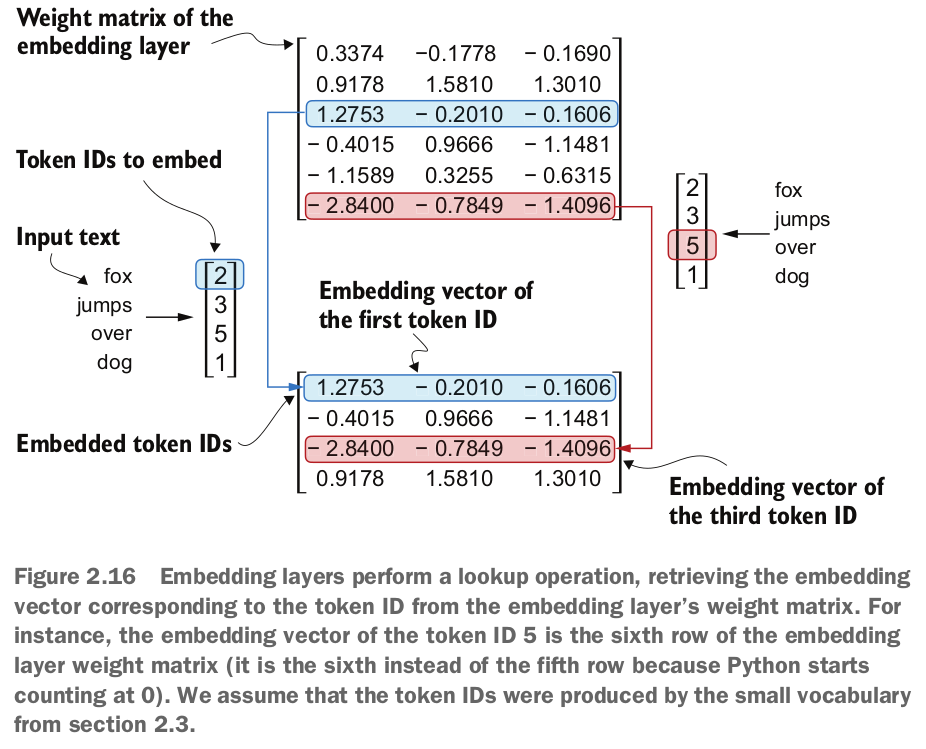

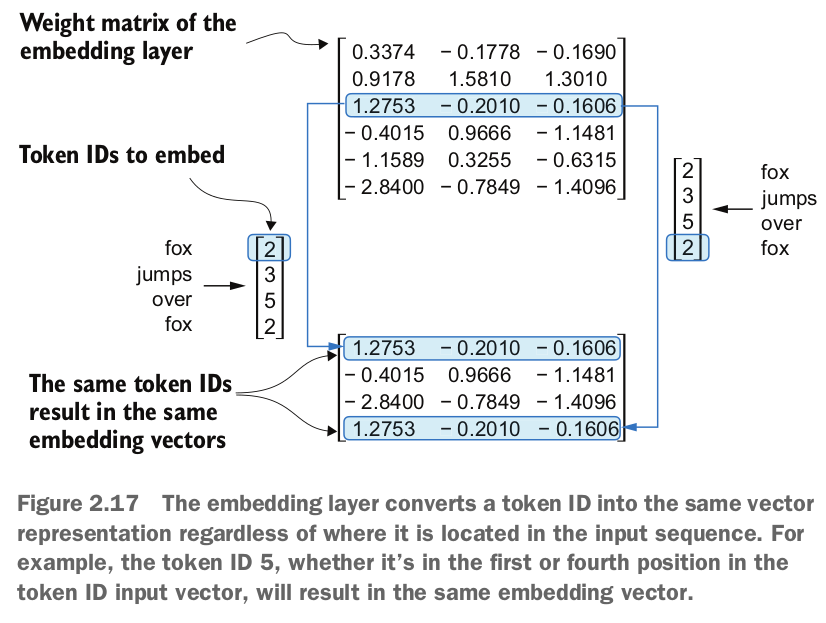

Em princípio, a incorporação determinística e independente da posição do ID do token é boa para fins de reprodutibilidade. No entanto, como o mecanismo de autoatenção dos LLMs também é independente da posição, é útil injetar informações adicionais sobre a posição no LLM.

Para isso, podemos usar duas categorias amplas de incorporações com reconhecimento de posição: incorporações posicionais relativas e incorporações posicionais absolutas. Incorporações posicionais absolutas estão diretamente associadas a posições específicas em uma sequência. Para cada posição na sequência de entrada, uma incorporação única é adicionada à incorporação do token para indicar sua localização exata. Por exemplo, o primeiro token terá uma incorporação posicional específica, o segundo token terá outra incorporação distinta e assim por diante, conforme ilustrado na figura 2.18.

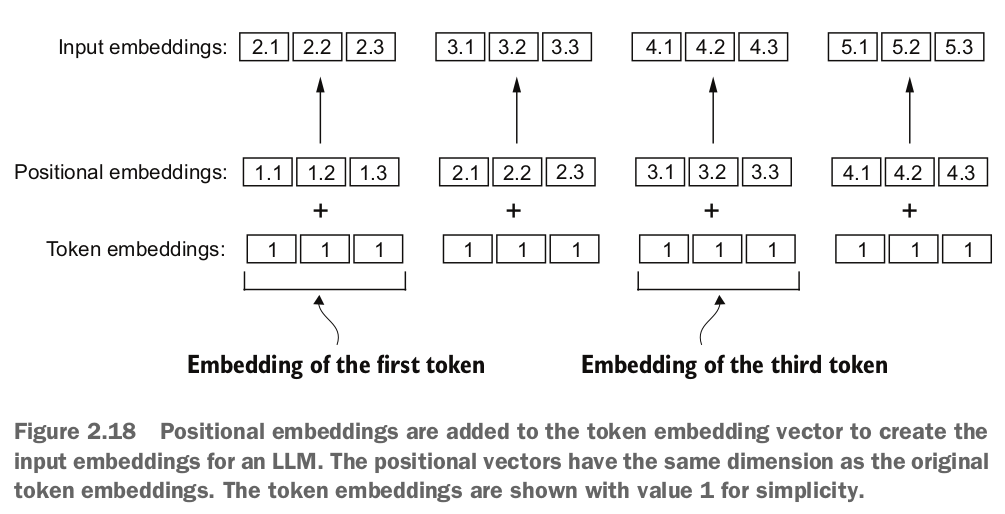

Em vez de focar na posição absoluta de um token, a ênfase dos embeddings posicionais relativos está na posição relativa ou distância entre os tokens. Isso significa que o modelo aprende as relações em termos de "quão distantes" em vez de "em qual posição exata". A vantagem aqui é que o modelo pode generalizar melhor para sequências de comprimentos variados, mesmo que não tenha observado tais comprimentos durante o treinamento.

Ambos os tipos de embeddings posicionais visam aumentar a capacidade dos LLMs de entender a ordem e as relações entre os tokens, garantindo previsões mais precisas e sensíveis ao contexto. A escolha entre eles geralmente depende da aplicação específica e da natureza dos dados processados.

---

$\large \textbf{Embeddings Posicionais: A Matemática da Posição}$

A ideia central dos embeddings posicionais é adicionar informação sobre a *posição* de um token em uma sequência ao seu embedding de conteúdo (o embedding que representa o significado da palavra). Isso permite que modelos como os Transformers, que não têm noção intrínima de ordem, entendam a sequência.

#### **1. Embedding Posicional Absoluto**

Este é o tipo mais comum e o que geralmente se refere quando se fala em "embeddings posicionais" em Transformers originais.

**A Ideia:** Para cada posição $pos$ na sequência (0, 1, 2, ...), existe um vetor de embedding posicional $PE_{pos}$. Este vetor é somado ao embedding de conteúdo do token que está naquela posição.

**A Matemática:**

A função mais conhecida para gerar esses vetores posicionais é a proposta no artigo "Attention Is All You Need" (Transformer original):

Para uma posição $pos$ e uma dimensão $i$ dentro do vetor de embedding posicional:

* Se $i$ é um índice **par** (0, 2, 4, ...):
    $$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
* Se $i$ é um índice **ímpar** (1, 3, 5, ...):
    $$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Onde:
* $pos$: A posição do token na sequência (começando de 0).
* $d_{model}$: A dimensão total do embedding (a mesma dimensão do embedding de conteúdo, para que possam ser somados).
* $i$: O índice da dimensão dentro do vetor de embedding posicional (de 0 a $d_{model}-1$).

**Visualizando a Operação:**

Imagine que você tem um token $T_k$ (com ID $k$) na posição $pos$.
1.  Você primeiro obtém o embedding de conteúdo (significado) para $T_k$ da sua matriz de embedding: $E_{conteudo}(T_k)$. Este é um vetor de $d_{model}$ dimensões.
2.  Você calcula o vetor de embedding posicional $PE_{pos}$ para a posição $pos$ usando as fórmulas de seno/cosseno. Este também é um vetor de $d_{model}$ dimensões.
3.  O embedding final (que será alimentado ao resto do modelo) é a **soma elemento a elemento** desses dois vetores:
    $$E_{final}(T_k, pos) = E_{conteudo}(T_k) + PE_{pos}$$

**Exemplo Numérico Simplificado (apenas para ilustrar a soma):**

Suponha:
* $E_{conteudo}(\text{token com ID 2}) = [0.3374, -0.1778, -0.1690]$ (do seu exemplo original)
* Para a posição $pos=0$, o $PE_0$ (calculado pelas fórmulas) = $[0.1, 0.2, 0.3]$
* Para a posição $pos=1$, o $PE_1$ (calculado pelas fórmulas) = $[0.4, 0.5, 0.6]$

Se o token com ID 2 estiver na **posição 0**:
$E_{final}(\text{ID 2, pos 0}) = [0.3374, -0.1778, -0.1690] + [0.1, 0.2, 0.3] = [0.4374, 0.0222, 0.1310]$

Se o token com ID 2 estiver na **posição 1**:
$E_{final}(\text{ID 2, pos 1}) = [0.3374, -0.1778, -0.1690] + [0.4, 0.5, 0.6] = [0.7374, 0.3222, 0.4310]$

Perceba que, embora o embedding de conteúdo seja o mesmo, o embedding final é diferente para a mesma palavra em posições diferentes, pois ele **incorpora a informação da posição**.

**Por que seno/cosseno?**
* Eles fornecem valores únicos para cada posição.
* Eles permitem que o modelo generalize para sequências de comprimento maior do que as vistas durante o treinamento.
* Existe uma propriedade de que $PE_{pos+k}$ pode ser representado como uma função linear de $PE_{pos}$, o que ajuda o modelo a entender distâncias relativas entre posições.

#### **2. Embedding Posicional Relativo**

Enquanto os embeddings posicionais absolutos somam a informação da posição ao embedding do token, os embeddings posicionais **relativos** não codificam diretamente a posição absoluta, mas sim a **distância relativa** entre os tokens.

**A Ideia:** Em vez de ter um vetor fixo para cada posição absoluta, a informação posicional é incorporada nas operações de atenção, ou seja, na forma como um token "olha" para os outros tokens na sequência. Isso geralmente envolve a modificação das matrizes de chave ($K$) e valor ($V$) ou da matriz de consulta ($Q$) da autoatenção para incorporar essa noção de distância.

**A Matemática (Conceitual):**
Não há uma fórmula única como para o absoluto, pois varia entre as implementações (e.g., Transformer-XL, T5, ALiBi).
* **Modificação da pontuação de atenção:** Em vez de calcular a pontuação de atenção apenas com $Q^T K$, você adiciona um termo que depende da distância relativa entre as posições $i$ e $j$.

$$
\text{Attention}(Q, K) = \dfrac{(Q K^T + \text{Termo Relativo})}{\sqrt{d_k}}
$$

O $Termo\ Relativo$ é aprendido e representa a influência que a posição $j$ tem sobre a posição $i$ baseada na sua distância $(j-i)$.

* **Parâmetros aprendíveis:** Diferentemente do embedding posicional absoluto baseado em seno/cosseno, os embeddings posicionais relativos muitas vezes envolvem a aprendizagem de um conjunto de vetores para diferentes distâncias relativas (por exemplo, um vetor para distância 1, outro para distância 2, etc.).

**Vantagem:** Modelos com embeddings posicionais relativos tendem a ser melhores em generalizar para sequências muito longas, pois eles não estão presos a um limite máximo de posições absolutas vistas durante o treinamento.

### **Quatro Embeddings Iguais: O Que Acontece?**

Você perguntou: "quando tenho por exemplo quatro embedding iguais, o primeiro embedding permanece inalterado e os outros três que são modificados como é que funciona isso?"

Isso se refere a **tokens que se repetem na sequência de entrada**. Por exemplo, na frase "The **cat** sat on the mat and the **cat** slept."

Vamos usar o exemplo que você tem na imagem, onde o ID 2 (representando "fox") aparece duas vezes:

`[2, 3, 5, 2]` (para "fox jumps over fox")

Aqui está o que acontece, considerando os **embeddings posicionais absolutos**:

1.  **Obtenção dos Embeddings de Conteúdo:**
    * Para o primeiro `2` (posição 0): O modelo busca o embedding de "fox" (ID 2): $[1.2753, -0.2010, -0.1606]$.
    * Para o `3` (posição 1): O modelo busca o embedding de "jumps" (ID 3): $[-0.4015, 0.9666, -1.1481]$.
    * Para o `5` (posição 2): O modelo busca o embedding de "over" (ID 5): $[-2.8400, -0.7849, -1.4096]$.
    * Para o segundo `2` (posição 3): O modelo busca o embedding de "fox" (ID 2): $[1.2753, -0.2010, -0.1606]$.

    **Neste ponto, a matriz de embedding (e a Figura 2.17) está correta: o embedding de conteúdo para o ID 2 é *sempre* o mesmo, independentemente de quantas vezes ele apareça na sequência.**

2.  **Adição dos Embeddings Posicionais:**
    * Agora, para cada posição, um vetor de embedding posicional *único para aquela posição* é gerado (ou recuperado, se for aprendível) e **somado** ao embedding de conteúdo.

    Vamos chamar $PE_0, PE_1, PE_2, PE_3$ os embeddings posicionais para as posições 0, 1, 2 e 3, respectivamente. Esses $PE$ são **diferentes** para cada posição.

    * **Token 'fox' (ID 2) na Posição 0:**
        $$E_{final}(\text{ID 2, pos 0}) = E_{conteudo}(\text{ID 2}) + PE_0$$

    * **Token 'jumps' (ID 3) na Posição 1:**
        $$E_{final}(\text{ID 3, pos 1}) = E_{conteudo}(\text{ID 3}) + PE_1$$

    * **Token 'over' (ID 5) na Posição 2:**
        $$E_{final}(\text{ID 5, pos 2}) = E_{conteudo}(\text{ID 5}) + PE_2$$

    * **Token 'fox' (ID 2) na Posição 3:**
        $$E_{final}(\text{ID 2, pos 3}) = E_{conteudo}(\text{ID 2}) + PE_3$$

**Conclusão:**

* **O embedding de conteúdo de um token *nunca é alterado* se o token se repete.** O ID 2 ("fox") sempre será mapeado para o mesmo vetor de significado $[1.2753, -0.2010, -0.1606]$ da matriz de embedding.
* **O que muda é o *embedding posicional* que é adicionado a ele.** Como cada posição tem um $PE_{pos}$ diferente, o **vetor final de entrada para o Transformer** para cada ocorrência de "fox" será diferente.

Então, você terá:
* `[1.2753, -0.2010, -0.1606] + PE_0` para o primeiro "fox".
* `[1.2753, -0.2010, -0.1606] + PE_3` para o segundo "fox".

Esses dois vetores finais (um para cada "fox") serão numericamente diferentes, permitindo que o mecanismo de autoatenção os trate como entidades distintas, mesmo que representem a mesma palavra, porque agora eles carregam a informação de sua posição na frase.

Isso é fundamental para que o modelo entenda, por exemplo, qual "fox" está agindo ou sendo afetado em uma frase com múltiplas ocorrências da mesma palavra.

---

Os modelos GPT da OpenAI usam embeddings posicionais absolutos que são otimizados durante o processo de treinamento, em vez de serem fixos ou predefinidos como as codificações posicionais no modelo de transformador original. Esse processo de otimização faz parte do próprio treinamento do modelo. Por enquanto, vamos criar os embeddings posicionais iniciais para criar as entradas do LLM.

Anteriormente, focamos em tamanhos de incorporação muito pequenos para simplificar. Agora, vamos considerar tamanhos de incorporação mais realistas e úteis e codificar os tokens de entrada em uma representação vetorial de 256 dimensões, que é menor do que a usada no modelo GPT-3 original (no GPT-3, o tamanho de incorporação é de 12.288 dimensões), mas ainda razoável para experimentação. Além disso, assumimos que os IDs de token foram criados pelo tokenizador BPE que implementamos anteriormente, que tem um tamanho de vocabulário de 50.257:

In [ ]:
# Define o tamanho do vocabulário.
# Este número representa a quantidade total de tokens únicos que o modelo pode entender.
# Para o tokenizador BPE usado neste exemplo (baseado no modelo gpt2 do tiktoken),
# o tamanho do vocabulário é 50257. Isso inclui palavras, subpalavras, caracteres
# e tokens especiais.
vocab_size = 50257

# Define a dimensão do espaço de embedding.
# Esta é a dimensão de cada vetor de embedding que representará um token.
# Cada token será mapeado para um vetor de números reais com 256 dimensões.
# Em modelos maiores como o GPT-3, essa dimensão pode ser muito maior (por exemplo, 12288).
# Uma dimensão maior geralmente permite que o modelo capture nuances mais finas
# no significado e nas relações entre os tokens, mas requer mais memória e poder computacional.
output_dim = 256

# Cria uma camada de embedding usando a classe Embedding do PyTorch (torch.nn.Embedding).
# Esta camada é essencialmente uma tabela de lookup.
# Quando você passa um ID de token para esta camada, ela retorna o vetor de embedding
# correspondente a esse ID.
# - O primeiro argumento (vocab_size) define o número de linhas na tabela de lookup.
#   Cada linha corresponde a um ID de token no vocabulário.
# - O segundo argumento (output_dim) define o número de colunas em cada linha,
#   que é a dimensão do vetor de embedding para cada token.
# Os pesos desta camada (os vetores de embedding) são inicialmente aleatórios
# e serão aprendidos (otimizados) durante o treinamento do modelo.
# O objeto 'token_embedding_layer' agora pode ser usado como uma função para
# converter tensores de IDs de token em tensores de embeddings.
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Usando o `token_embedding_layer` anterior, se amostrarmos dados do carregador de dados, incorporaremos cada token de cada lote em um vetor de 256 dimensões. Se tivermos um lote de 8 com quatro tokens cada, o resultado será um tensor $8 × 4 × 256$.

Vamos instanciar o carregador de dados (consulte a seção 2.6) primeiro:

In [ ]:
# Define o comprimento máximo da sequência de entrada (context_length).
# Este valor determina quantos tokens um único exemplo de treinamento conterá.
# Em outras palavras, é o tamanho da "janela" de texto que o modelo verá por vez.
# Um max_length maior permite que o modelo considere mais contexto, mas aumenta
# a complexidade e o uso de memória. Aqui, é definido como 4 apenas para fins de demonstração.
max_length = 4

# Cria um DataLoader usando a função create_dataloader_v1.
# Esta função (definida anteriormente) encapsula a lógica para:
# 1. Inicializar um tokenizador (tiktoken com modelo gpt2).
# 2. Criar um Dataset customizado (GPTDatasetV1) que tokeniza o texto completo
#    e gera pares de entrada-alvo usando uma janela deslizante.
# 3. Configurar um DataLoader para carregar esses pares em lotes.
#
# Parâmetros passados para create_dataloader_v1:
# - raw_text: O texto completo do conto de Edith Wharton, que será a fonte de dados.
# - batch_size=8: Define que cada lote de dados retornado pelo DataLoader conterá 8 amostras.
#                 Isso significa que os tensores de entrada e alvo terão a forma [8, max_length].
# - max_length=max_length: Passa o valor definido acima (4) como o comprimento da sequência para
#                          as amostras no Dataset.
# - stride=max_length: Define o passo da janela deslizante para 4. Como o passo é igual ao
#                      comprimento máximo, as janelas deslizantes não se sobrepõem.
#                      Cada nova amostra começa exatamente onde a anterior terminou.
# - shuffle=False: Desativa o embaralhamento dos dados. Isso é útil para demonstração
#                  ou depuração, pois garante que a ordem dos lotes seja fixa.
#                  Para treinamento real, shuffle=True é geralmente recomendado.
# O objeto 'dataloader' é um iterável que fornecerá lotes de dados quando percorrido.
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)

# Cria um iterador a partir do DataLoader.
# Um iterador permite que você obtenha elementos de um iterável (como um DataLoader)
# um por um, usando a função 'next()'.
# 'data_iter' agora pode ser usado para buscar os próximos lotes de dados.
data_iter = iter(dataloader)

# Obtém o próximo (neste caso, o primeiro) lote de dados do iterador.
# A função 'next()' busca o próximo item do iterador. Como o DataLoader foi configurado
# para retornar lotes de 8 amostras, 'next(data_iter)' retornará uma tupla de dois tensores PyTorch:
# - inputs: Um tensor contendo as sequências de entrada para o lote. Sua forma será [batch_size, max_length], ou seja, [8, 4].
# - targets: Um tensor contendo as sequências alvo correspondentes para o lote. Sua forma também será [8, 4].
#            Cada sequência em 'targets' é a sequência correspondente em 'inputs' deslocada em um token para a direita.
inputs, targets = next(data_iter)

# Imprime um rótulo para a saída dos IDs de token de entrada.
print("Token IDs:\n", inputs)

# Imprime um rótulo para a saída da forma (dimensões) do tensor de entradas.
print("\nInputs shape:\n", inputs.shape)

# O tensor 'inputs' agora contém 8 sequências, cada uma com 4 IDs de token.
# Por exemplo, o primeiro elemento de 'inputs' (inputs[0]) é um tensor de 4 IDs
# que representa os primeiros 4 tokens da primeira amostra no lote.
# A forma 'torch.Size([8, 4])' indica que o tensor tem 8 linhas (samples)
# e 4 colunas (tokens por sample).

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


Como podemos ver, o tensor de ID do token tem dimensão $8 × 4$, o que significa que o lote de dados consiste em oito amostras de texto com quatro tokens cada.

Vamos agora usar a camada de incorporação para incorporar esses IDs de token em vetores de 256 dimensões:

In [ ]:
# Aplica a camada de embedding aos IDs de token de entrada.
# 'inputs' é um tensor PyTorch que contém os IDs de token para o lote atual.
# Sua forma é [batch_size, max_length], que neste exemplo é [8, 4].
# O objeto 'token_embedding_layer' é uma instância de torch.nn.Embedding
# configurada para mapear IDs de token para vetores de 'output_dim' (256) dimensões.
# Quando você "chama" a camada de embedding passando um tensor de IDs,
# ela realiza uma operação de "lookup" (consulta) na sua tabela de pesos.
# Para cada ID no tensor 'inputs', a camada recupera o vetor de embedding correspondente.
# A forma do tensor de saída será [batch_size, max_length, output_dim].
# Isso significa que para cada amostra no lote (8 amostras), e para cada token na sequência (4 tokens),
# teremos um vetor de embedding de 256 dimensões.
token_embeddings = token_embedding_layer(inputs)

# Imprime a forma do tensor resultante 'token_embeddings'.
# A forma esperada é [8, 4, 256], onde:
# - 8 é o tamanho do lote (número de sequências no lote).
# - 4 é o comprimento máximo da sequência (número de tokens por sequência).
# - 256 é a dimensão do vetor de embedding para cada token.
# Esta saída confirma que a camada de embedding transformou os IDs de token inteiros
# em vetores numéricos densos de alta dimensão, prontos para serem processados pelas próximas camadas do modelo.
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [ ]:
print(token_embeddings[0][0])

tensor([ 0.3045, -2.2610, -0.4094,  0.0639,  0.6914,  0.5580,  0.6737,  0.3529,
        -1.6041,  0.7378, -2.0801, -1.2638, -2.6987, -0.7529,  0.4136, -0.2739,
        -1.2756,  0.6747, -0.7876,  1.6812,  1.0487,  1.1066,  0.8875,  0.9136,
        -1.6750, -0.6971,  0.3586,  0.8690,  2.5099, -0.1772,  0.1694,  1.2960,
        -0.6128, -1.2490, -0.4403,  0.1905,  0.6922,  0.0407,  1.6617,  0.6481,
        -2.6693, -0.2325, -0.9739, -0.3167,  1.2218,  0.2183,  0.1635,  0.1606,
         0.4934, -2.9808,  1.2587,  1.6194, -1.3202,  0.8469, -1.7244, -0.1826,
        -1.4563,  0.7982,  0.6178,  0.7671, -0.6065, -0.0991,  0.8244, -0.0905,
         1.0390,  0.0547, -0.9186,  1.6689,  0.8569, -0.3857,  1.4014, -0.9274,
        -0.3806, -0.7498,  0.5601, -0.2109, -0.2645, -0.5520,  0.2655,  0.8458,
         0.3985,  1.1195,  0.1514, -0.8613, -0.6073, -1.2900,  0.8032, -0.3202,
        -0.1642,  0.1196, -2.3089,  1.7637,  0.5697,  2.0491, -0.7955,  1.0723,
        -0.4156,  0.9476, -1.3910,  0.56

A saída do tensor de $8 × 4 × 256$ dimensões mostra que cada ID de token agora está incorporado como um vetor de 256 dimensões. Para a abordagem de incorporação absoluta de um modelo GPT, precisamos apenas criar outra camada de incorporação com a mesma dimensão de incorporação que a camada `token_embedding_layer`:

In [ ]:
# Define o comprimento do contexto (context_length) para ser igual ao max_length.
# O comprimento do contexto determina o número máximo de tokens que o modelo pode processar em uma única sequência.
# Neste caso, ele é definido como 4, correspondendo ao max_length que usamos para fatiar os dados.
# Para modelos GPT, o context_length é um hiperparâmetro fixo da arquitetura.
context_length = max_length

# Cria uma camada de embedding para as posições (pos_embedding_layer).
# Esta camada mapeará as posições dos tokens (0, 1, 2, ...) para vetores de embedding.
# Ela é uma instância de torch.nn.Embedding, similar à camada de embedding de tokens.
# Parâmetros:
# - context_length: O número total de posições que a camada precisa suportar (0 a context_length - 1).
#                   Cada posição terá seu próprio vetor de embedding. Neste caso, 4 posições (0, 1, 2, 3).
# - output_dim: A dimensão do vetor de embedding posicional. É a mesma dimensão do embedding de token (256)
#               para que os dois possam ser somados posteriormente.
# Os pesos desta camada (os vetores de embedding posicionais para cada posição) são inicialmente aleatórios
# e, neste tipo de embedding posicional absoluto, também serão aprendidos durante o treinamento.
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# Gera os embeddings posicionais para todas as posições possíveis dentro do contexto definido.
# - torch.arange(context_length): Cria um tensor PyTorch contendo uma sequência de inteiros de 0 até context_length - 1.
#                                 Neste caso, será torch.tensor([0, 1, 2, 3]).
#                                 Este tensor representa as posições dentro de uma sequência de comprimento 4.
# - pos_embedding_layer(...): Passa o tensor de posições para a camada de embedding posicional.
#                             A camada lookup os vetores de embedding correspondentes a cada posição (0, 1, 2, 3).
#                             O resultado é um tensor onde cada linha é o vetor de embedding para a posição correspondente.
#                             Sua forma será [context_length, output_dim].
# O tensor 'pos_embeddings' contém os vetores de embedding posicionais para cada posição de 0 a 3.
pos_embeddings = pos_embedding_layer(torch.arange(context_length))

# Imprime a forma (dimensões) do tensor resultante 'pos_embeddings'.
# A forma esperada é [4, 256], onde:
# - 4 é o número de posições para as quais geramos embeddings (de 0 a 3).
# - 256 é a dimensão do vetor de embedding para cada posição.
# Esta saída confirma que temos um vetor de 256 dimensões para cada uma das 4 posições no contexto.
print(pos_embeddings.shape)

torch.Size([4, 256])


A entrada para `pos_embeddings` geralmente é um vetor de espaço reservado `torch.arange(context_length)`, que contém uma sequência de números 0, 1, ..., até o comprimento máximo de entrada –1. `context_length` é uma variável que representa o tamanho de entrada suportado do LLM. Aqui, escolhemos um tamanho semelhante ao comprimento máximo do texto de entrada. Na prática, o texto de entrada pode ser maior que o comprimento de contexto suportado, caso em que precisamos truncar o texto.

Como podemos ver, o tensor de incorporação posicional consiste em quatro vetores de 256 dimensões. Agora podemos adicioná-los diretamente aos tokens de incorporação, onde o PyTorch adicionará o tensor `pos_embeddings` de $4 × 256$ dimensões a cada tensor de incorporação de tokens de $4 × 256$ dimensões em cada um dos oito lotes:

In [ ]:
# Realiza a soma dos embeddings de token e dos embeddings posicionais.
# 'token_embeddings' é um tensor que representa os embeddings de conteúdo (significado) de cada token no lote.
# Sua forma é [batch_size, max_length, output_dim], neste caso [8, 4, 256].
# 'pos_embeddings' é um tensor que representa os embeddings posicionais para cada posição na sequência.
# Sua forma é [max_length, output_dim], neste caso [4, 256].
#
# O PyTorch realiza uma operação de "broadcasting" (transmissão) aqui.
# Como 'pos_embeddings' tem menos dimensões que 'token_embeddings',
# o PyTorch "expande" 'pos_embeddings' para que suas dimensões coincidam com as de 'token_embeddings'
# para a soma. Ele essencialmente duplica o tensor 'pos_embeddings' ao longo da primeira dimensão (batch_size),
# transformando-o conceitualmente em um tensor de forma [8, 4, 256].
# O primeiro vetor de pos_embeddings (para a posição 0) é somado a todos os primeiros vetores de token_embeddings
# em cada amostra do lote. O segundo vetor de pos_embeddings (para a posição 1) é somado a todos os segundos vetores
# de token_embeddings, e assim por diante.
#
# A soma elemento a elemento é então realizada entre os dois tensores (agora com formas compatíveis).
# O resultado é um novo tensor 'input_embeddings' onde cada vetor de embedding final
# é a soma do embedding de conteúdo original e o embedding posicional correspondente à sua posição.
# Esta soma injeta informação sobre a posição de cada token em seu vetor de representação.
input_embeddings = token_embeddings + pos_embeddings

# Imprime a forma (dimensões) do tensor resultante 'input_embeddings'.
# A forma deste tensor será a mesma que a do 'token_embeddings' original,
# ou seja, [batch_size, max_length, output_dim], neste caso [8, 4, 256].
# Isso confirma que a operação de soma posicional foi realizada e o resultado
# mantém a estrutura necessária para as próximas camadas do modelo.
# Este tensor 'input_embeddings' é a entrada final para o bloco Transformer (atenção e feedforward).
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Os `input_embeddings` que criamos, conforme resumido na figura 2.19, são os exemplos de entrada incorporados que agora podem ser processados pelos principais módulos LLM, que começaremos a implementar no próximo capítulo.

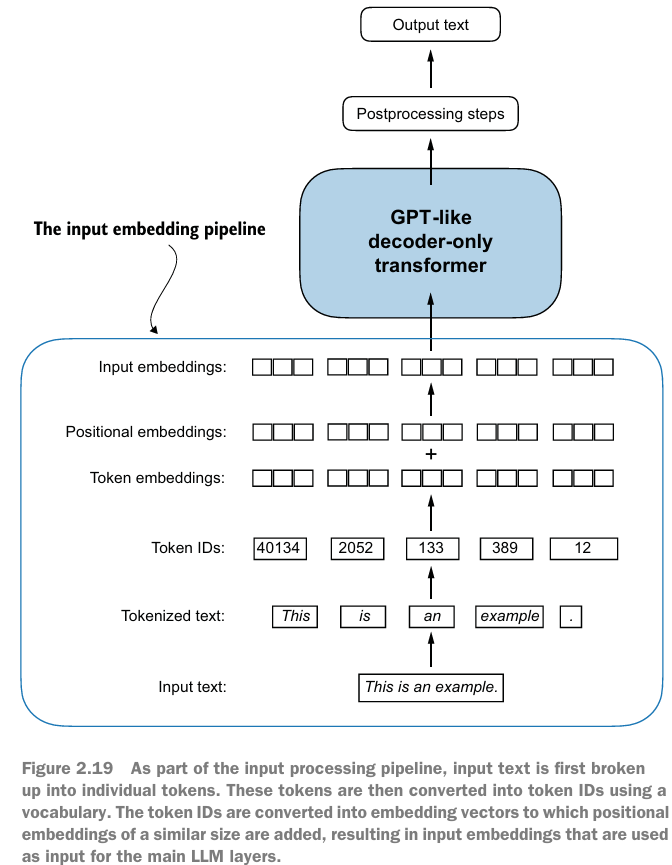

## **Resumo**

- **LLMs exigem conversão de texto em vetores numéricos (embeddings)**, pois não processam texto bruto. Embeddings transformam dados discretos (como palavras ou imagens) em espaços vetoriais contínuos, compatíveis com operações de redes neurais.  

- **O texto bruto é dividido em tokens** (palavras ou caracteres), que são convertidos em representações inteiras (IDs de tokens).  

- **Tokens especiais** (como `<|unk|>` e `<|endoftext|>`**) são adicionados para melhorar o entendimento do modelo**, lidando com contextos como palavras desconhecidas ou delimitadores entre textos não relacionados.  

- **O tokenizador Byte Pair Encoding (BPE)**, usado em LLMs como GPT-2 e GPT-3, processa palavras desconhecidas eficientemente, dividindo-as em subwords ou caracteres individuais.  

- **Uma abordagem de janela deslizante** é aplicada aos dados tokenizados para gerar pares de entrada-alvo no treinamento de LLMs.  

- **Camadas de embedding no PyTorch funcionam como uma operação de busca**, recuperando vetores correspondentes aos IDs de tokens. Os vetores resultantes fornecem representações contínuas dos tokens, essenciais para treinar modelos de deep learning como LLMs.  

- **Embora embeddings de tokens forneçam representações consistentes**, eles não capturam a posição do token em uma sequência. Para resolver isso, existem dois tipos principais de embeddings posicionais:  
  - **Absolutos**: Usados em modelos GPT da OpenAI, são somados aos embeddings de tokens e otimizados durante o treinamento.  
  - **Relativos**: Incorporam informações de posição relativa entre tokens.  